# Comprehensive SDI Analysis: Delirium Study

This notebook provides a comprehensive analysis of Spectral Dimensionality Index (SDI) results comparing Healthy Controls, ICU patients, and ICU patients with Delirium.

## Overview

**SDI Interpretation:**
- **Low SDI** = High structural coupling (functional signal aligned with structural connectivity)
- **High SDI** = Decoupling (functional signal independent of structural connectivity)

**Groups Analyzed:**
- Healthy Controls (HC): n=12 subjects
- ICU: n=5 subjects  
- ICU Delirium: n=12 subjects

**Analysis includes:**
1. Data overview and descriptive statistics
2. Statistical assumption checks (normality, variance homogeneity)
3. Primary statistical tests (Kruskal-Wallis)
4. Post-hoc pairwise comparisons
5. Regional analysis (12 brain regions/networks)
6. Parcel-level analysis
7. Structural coupling analysis (low SDI regions)
8. Key findings and interpretations


## 1. Setup and Data Loading


In [1]:
# Import necessary libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path for imports
# Navigate from notebook directory: results/analysis/notebook -> github/SDI_delirium
notebook_dir = Path().resolve()
sdi_dir = notebook_dir.parents[2]  # Go up to github/SDI_delirium
sys.path.insert(0, str(sdi_dir))

# Import project utilities
from utils.load_config import load_config
from utils.group import get_group_color
from config import mlp_param

# Apply matplotlib parameters
plt.rcParams.update(mlp_param.MPL_PARAMS)

# Set up paths
base_dir = Path().resolve().parent  # results/analysis directory (parent of notebook/)
results_dir = base_dir
descriptive_dir = results_dir / "descriptive_stats"
statistical_dir = results_dir / "statistical_tests"
figures_dir = results_dir / "figures"

# Define colors for plotting 
colors = [get_group_color().get('HC', '#3498DB'), 
          get_group_color().get('CR', '#E67E22'),
          get_group_color().get('Delirium', '#C0392B')]

# Load config
config = load_config()

print("Setup complete!")
print(f"Results directory: {results_dir}")
print(f"Config loaded: {config['dir']['SDI_dir']}")


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Setup complete!
Results directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/github/SDI_delirium/results/analysis
Config loaded: /media/RCPNAS/Data/Delirium/Delirium_Rania/github/SDI_delirium


In [2]:
# Load all descriptive statistics CSV files
group_level_stats = pd.read_csv(descriptive_dir / "sdi_bandpass_group_level_stats.csv")
parcel_level_stats = pd.read_csv(descriptive_dir / "sdi_bandpass_parcel_level_stats.csv")
distribution_stats = pd.read_csv(descriptive_dir / "sdi_bandpass_distribution_stats.csv")
outliers_df = pd.read_csv(descriptive_dir / "sdi_bandpass_outliers.csv")

# Load all statistical test CSV files
normality_tests = pd.read_csv(statistical_dir / "sdi_bandpass_normality_tests.csv")
variance_tests = pd.read_csv(statistical_dir / "sdi_bandpass_variance_tests.csv")
primary_test = pd.read_csv(statistical_dir / "sdi_bandpass_primary_test.csv")
posthoc_tests = pd.read_csv(statistical_dir / "sdi_bandpass_posthoc_tests.csv")
regional_tests = pd.read_csv(statistical_dir / "sdi_bandpass_regional_tests.csv")
regional_stats = pd.read_csv(statistical_dir / "sdi_bandpass_regional_stats.csv")
parcel_comparisons = pd.read_csv(statistical_dir / "sdi_bandpass_parcel_comparisons.csv")
significant_parcels_fdr = pd.read_csv(statistical_dir / "sdi_bandpass_significant_parcels_fdr.csv")
significant_parcels_bonf = pd.read_csv(statistical_dir / "sdi_bandpass_significant_parcels_bonferroni.csv")
test_recommendations = pd.read_csv(statistical_dir / "sdi_bandpass_test_recommendations.csv")

print("All data files loaded successfully!")
print(f"\nLoaded files:")
print(f"  - Group level stats: {len(group_level_stats)} rows")
print(f"  - Parcel level stats: {len(parcel_level_stats)} rows")
print(f"  - Regional tests: {len(regional_tests)} regions")
print(f"  - Significant parcels (FDR): {len(significant_parcels_fdr[significant_parcels_fdr['significant']==True])} parcels")
print(f"  - Significant parcels (Bonferroni): {len(significant_parcels_bonf[significant_parcels_bonf['significant']==True])} parcels")


All data files loaded successfully!

Loaded files:
  - Group level stats: 3 rows
  - Parcel level stats: 1287 rows
  - Regional tests: 13 regions
  - Significant parcels (FDR): 161 parcels
  - Significant parcels (Bonferroni): 63 parcels


## 2. Data Overview


In [4]:
# Display summary statistics for each group
print("=" * 80)
print("DATA OVERVIEW")
print("=" * 80)
print("\nGroup Summary Statistics:")
print("-" * 80)
display(group_level_stats[['group', 'n_subjects', 'n_parcels', 'n_observations', 
                            'mean', 'median', 'std', 'min', 'max']].round(3))

# Create a summary table
summary_table = group_level_stats[['group', 'n_subjects', 'n_parcels', 'n_observations']].copy()
summary_table.columns = ['Group', 'N Subjects', 'N Parcels', 'N Observations']
print("\n" + "=" * 80)
print("Sample Sizes:")
print("-" * 80)
display(summary_table)


DATA OVERVIEW

Group Summary Statistics:
--------------------------------------------------------------------------------


,group,n_subjects,n_parcels,n_observations,mean,median,std,min,max
0,ICU,5,430,2145,1.169,0.999,0.726,0.269,9.517
1,ICU Delirium,12,430,5148,1.183,1.032,0.743,0.216,8.537
2,Healthy Controls,12,430,5148,1.449,1.069,1.392,0.223,16.893



Sample Sizes:
--------------------------------------------------------------------------------


,Group,N Subjects,N Parcels,N Observations
0,ICU,5,430,2145
1,ICU Delirium,12,430,5148
2,Healthy Controls,12,430,5148


## 3. Assumption Checks Analysis

Before interpreting statistical test results, we must verify that the assumptions underlying our statistical tests are met (or justify the use of non-parametric tests).


### 3.1 Normality Tests


In [ ]:
# Display normality test results
print("=" * 80)
print("NORMALITY TESTS")
print("=" * 80)
print("\nResults:")
print("-" * 80)
display(normality_tests)

print("\nInterpretation:")
print("-" * 80)
for _, row in normality_tests.iterrows():
    group = row['group']
    test_used = row['test_used']
    pvalue = row['pvalue']
    is_normal = row['is_normal']
    
    print(f"\n{group}:")
    print(f"  Test used: {test_used}")
    print(f"  p-value: {pvalue:.2e}")
    print(f"  Normal distribution: {is_normal}")
    if pvalue < 0.001:
        print(f"  → Strong evidence against normality (p < 0.001)")
    elif pvalue < 0.05:
        print(f"  → Evidence against normality (p < 0.05)")
    else:
        print(f"  → No strong evidence against normality")

print("\n" + "=" * 80)
print("CONCLUSION: All groups show non-normal distributions (p < 0.001)")
print("→ Non-parametric tests (Kruskal-Wallis, Mann-Whitney U) are appropriate")
print("=" * 80)


NORMALITY TESTS

Results:
--------------------------------------------------------------------------------


,group,n,test_used,statistic,pvalue,is_normal
0,ICU,2150,shapiro_wilk,0.644924,0.0,False
1,ICU Delirium,5160,dagostino_pearson,4472.381961,0.0,False
2,Healthy Controls,5160,dagostino_pearson,4780.237871,0.0,False



Interpretation:
--------------------------------------------------------------------------------

ICU:
  Test used: shapiro_wilk
  p-value: 0.00e+00
  Normal distribution: False
  → Strong evidence against normality (p < 0.001)

ICU Delirium:
  Test used: dagostino_pearson
  p-value: 0.00e+00
  Normal distribution: False
  → Strong evidence against normality (p < 0.001)

Healthy Controls:
  Test used: dagostino_pearson
  p-value: 0.00e+00
  Normal distribution: False
  → Strong evidence against normality (p < 0.001)

CONCLUSION: All groups show non-normal distributions (p < 0.001)
→ Non-parametric tests (Kruskal-Wallis, Mann-Whitney U) are appropriate


### 3.2 Variance Homogeneity Tests


In [ ]:
# Display variance test results
print("=" * 80)
print("VARIANCE HOMOGENEITY TESTS")
print("=" * 80)
print("\nResults:")
print("-" * 80)
display(variance_tests)

print("\nInterpretation:")
print("-" * 80)
for _, row in variance_tests.iterrows():
    test_name = row['test']
    statistic = row['statistic']
    pvalue = row['pvalue']
    is_homogeneous = row['is_homogeneous']
    groups_tested = row['groups_tested']
    
    print(f"\n{test_name} test:")
    print(f"  Statistic: {statistic:.3f}")
    print(f"  p-value: {pvalue:.2e}")
    print(f"  Variances homogeneous: {is_homogeneous}")
    print(f"  Groups tested: {groups_tested}")
    if pvalue < 0.001:
        print(f"  → Strong evidence of unequal variances (p < 0.001)")

print("\n" + "=" * 80)
print("CONCLUSION: Variances are NOT homogeneous across groups")
print("→ This further justifies the use of non-parametric tests")
print("=" * 80)


VARIANCE HOMOGENEITY TESTS

Results:
--------------------------------------------------------------------------------


,test,statistic,pvalue,is_homogeneous,groups_tested
0,levene,131.552199,2.907272e-57,False,"ICU, ICU Delirium, Healthy Controls"
1,bartlett,2453.576695,0.000000e+00,False,"ICU, ICU Delirium, Healthy Controls"



Interpretation:
--------------------------------------------------------------------------------

levene test:
  Statistic: 131.552
  p-value: 2.91e-57
  Variances homogeneous: False
  Groups tested: ICU, ICU Delirium, Healthy Controls
  → Strong evidence of unequal variances (p < 0.001)

bartlett test:
  Statistic: 2453.577
  p-value: 0.00e+00
  Variances homogeneous: False
  Groups tested: ICU, ICU Delirium, Healthy Controls
  → Strong evidence of unequal variances (p < 0.001)

CONCLUSION: Variances are NOT homogeneous across groups
→ This further justifies the use of non-parametric tests


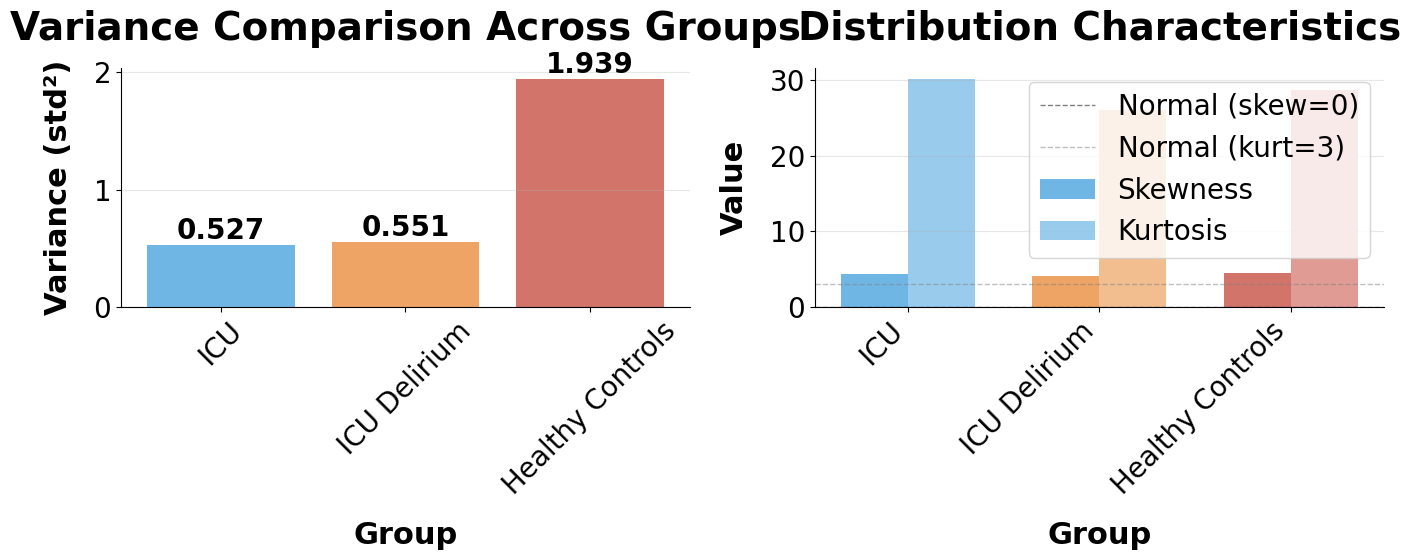


Distribution Characteristics:
--------------------------------------------------------------------------------

ICU:
  Skewness: 4.411 (positive = right-skewed)
  Kurtosis: 30.093 (normal = 3, higher = heavy tails)
  → Highly right-skewed distribution
  → Heavy-tailed distribution (many outliers)

ICU Delirium:
  Skewness: 4.075 (positive = right-skewed)
  Kurtosis: 25.962 (normal = 3, higher = heavy tails)
  → Highly right-skewed distribution
  → Heavy-tailed distribution (many outliers)

Healthy Controls:
  Skewness: 4.487 (positive = right-skewed)
  Kurtosis: 28.693 (normal = 3, higher = heavy tails)
  → Highly right-skewed distribution
  → Heavy-tailed distribution (many outliers)


In [6]:
# Visualize variance comparisons
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Variance comparison
group_vars = []
group_names = []
for group in group_level_stats['group'].values:
    group_data = group_level_stats[group_level_stats['group'] == group]
    group_vars.append(group_data['std'].values[0]**2)  # variance = std^2
    group_names.append(group)

axes[0].bar(group_names, group_vars, color=colors, alpha=0.7)
axes[0].set_xlabel('Group')
axes[0].set_ylabel('Variance (std²)')
axes[0].set_title('Variance Comparison Across Groups')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add variance values on bars
for i, (name, var) in enumerate(zip(group_names, group_vars)):
    axes[0].text(i, var, f'{var:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Distribution characteristics (skewness and kurtosis)
skewness = group_level_stats['skewness'].values
kurtosis = group_level_stats['kurtosis'].values

x = np.arange(len(group_names))
width = 0.35

axes[1].bar(x - width/2, skewness, width, label='Skewness', color=colors, alpha=0.7)
axes[1].bar(x + width/2, kurtosis, width, label='Kurtosis', color=colors, alpha=0.5)

axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Normal (skew=0)')
axes[1].axhline(y=3, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Normal (kurt=3)')

axes[1].set_xlabel('Group')
axes[1].set_ylabel('Value')
axes[1].set_title('Distribution Characteristics')
axes[1].set_xticks(x)
axes[1].set_xticklabels(group_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDistribution Characteristics:")
print("-" * 80)
for _, row in group_level_stats.iterrows():
    group = row['group']
    skew = row['skewness']
    kurt = row['kurtosis']
    print(f"\n{group}:")
    print(f"  Skewness: {skew:.3f} (positive = right-skewed)")
    print(f"  Kurtosis: {kurt:.3f} (normal = 3, higher = heavy tails)")
    if skew > 1:
        print(f"  → Highly right-skewed distribution")
    if kurt > 10:
        print(f"  → Heavy-tailed distribution (many outliers)")


### 3.3 Outlier Analysis


In [ ]:
# Analyze outliers
print("=" * 80)
print("OUTLIER ANALYSIS")
print("=" * 80)

# Display outlier statistics from distribution stats
print("\nOutlier Statistics (IQR method):")
print("-" * 80)
outlier_summary = distribution_stats[['group', 'n_observations', 'n_outliers_iqr', 'outlier_percentage']].copy()
outlier_summary.columns = ['Group', 'N Observations', 'N Outliers', 'Outlier %']
display(outlier_summary)

print("\nInterpretation:")
print("-" * 80)
for _, row in distribution_stats.iterrows():
    group = row['group']
    n_outliers = row['n_outliers_iqr']
    pct = row['outlier_percentage']
    print(f"{group}: {n_outliers} outliers ({pct:.2f}%)")
    if pct > 5:
        print(f"  → High proportion of outliers may affect parametric tests")

print("\n" + "=" * 80)
print("Note: Non-parametric tests are robust to outliers")
print("=" * 80)


OUTLIER ANALYSIS

Outlier Statistics (IQR method):
--------------------------------------------------------------------------------


,Group,N Observations,N Outliers,Outlier %
0,ICU,2145,110,5.128205
1,ICU Delirium,5148,240,4.662005
2,Healthy Controls,5148,476,9.246309



Interpretation:
--------------------------------------------------------------------------------
ICU: 110 outliers (5.13%)
  → High proportion of outliers may affect parametric tests
ICU Delirium: 240 outliers (4.66%)
Healthy Controls: 476 outliers (9.25%)
  → High proportion of outliers may affect parametric tests

Note: Non-parametric tests are robust to outliers


## 4. Primary Statistical Test Results

The primary test determines whether there are any significant differences between the three groups overall.


In [ ]:
# Display primary test results
print("=" * 80)
print("PRIMARY STATISTICAL TEST: KRUSKAL-WALLIS")
print("=" * 80)
print("\nResults:")
print("-" * 80)
display(primary_test)

# Extract test details
test_name = primary_test['test_name'].values[0]
statistic = primary_test['statistic'].values[0]
pvalue = primary_test['pvalue'].values[0]
groups = primary_test['groups'].values[0]
n_groups = primary_test['n_groups'].values[0]

print("\nInterpretation:")
print("-" * 80)
print(f"Test: {test_name}")
print(f"Statistic: {statistic:.4f}")
print(f"p-value: {pvalue:.2e}")
print(f"Groups compared: {groups}")
print(f"Number of groups: {n_groups}")

if pvalue < 0.001:
    significance = "*** (p < 0.001)"
elif pvalue < 0.01:
    significance = "** (p < 0.01)"
elif pvalue < 0.05:
    significance = "* (p < 0.05)"
else:
    significance = "ns (not significant)"

print(f"\nSignificance: {significance}")

if pvalue < 0.05:
    print("\n✓ CONCLUSION: There are significant differences between groups")
    print("  → Proceed with post-hoc pairwise comparisons")
else:
    print("\n✗ CONCLUSION: No significant differences between groups overall")
    print("  → No need for post-hoc tests")

print("=" * 80)


PRIMARY STATISTICAL TEST: KRUSKAL-WALLIS

Results:
--------------------------------------------------------------------------------


,test_name,statistic,pvalue,groups,n_groups
0,Kruskal-Wallis,36.572618,1.143818e-08,"['Healthy Controls', 'ICU', 'ICU Delirium']",3



Interpretation:
--------------------------------------------------------------------------------
Test: Kruskal-Wallis
Statistic: 36.5726
p-value: 1.14e-08
Groups compared: ['Healthy Controls', 'ICU', 'ICU Delirium']
Number of groups: 3

Significance: *** (p < 0.001)

✓ CONCLUSION: There are significant differences between groups
  → Proceed with post-hoc pairwise comparisons


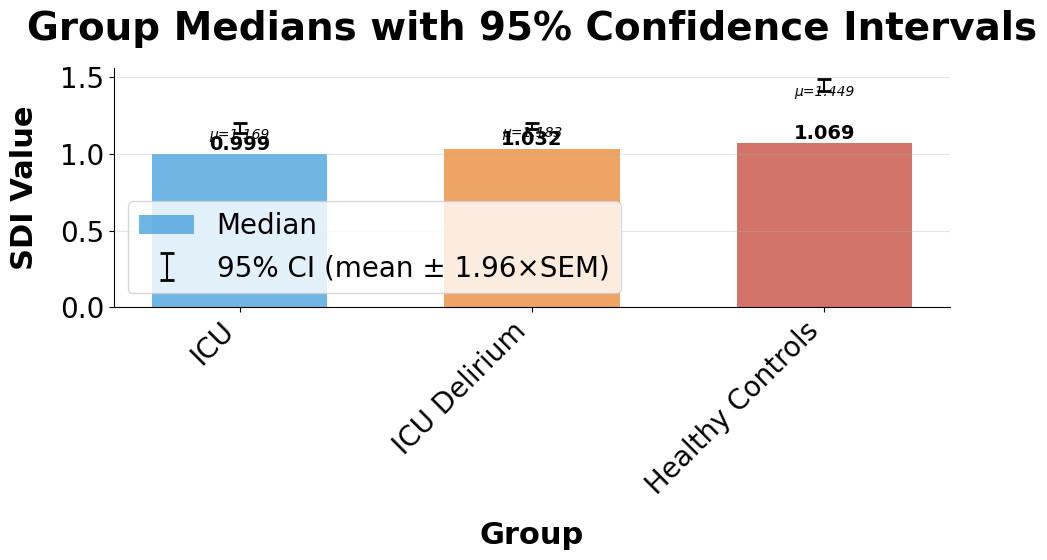


Key Observations:
--------------------------------------------------------------------------------
  - ICU: median = 0.999
  - ICU Delirium: median = 1.032
  - Healthy Controls: median = 1.069

  → Healthy Controls show higher SDI (more decoupling)
  → ICU groups show lower SDI (more structural coupling)


In [9]:
# Visualize group medians with confidence intervals
fig, ax = plt.subplots(figsize=(10, 6))

# Use local variables to avoid clashes
group_labels = group_level_stats['group'].values
medians_vals = group_level_stats['median'].values
means_vals = group_level_stats['mean'].values
stds_vals = group_level_stats['std'].values
sems_vals = group_level_stats['sem'].values

# Calculate approximate 95% CI (using SEM)
ci_lower = means_vals - 1.96 * sems_vals
ci_upper = means_vals + 1.96 * sems_vals

x_pos = np.arange(len(group_labels))
width = 0.6

# Ensure colors length matches number of groups
colors_local = colors[:len(group_labels)] if len(colors) >= len(group_labels) else ['#3498DB'] * len(group_labels)

# Plot medians
bars = ax.bar(x_pos, medians_vals, width, color=colors_local, alpha=0.7, label='Median')

# Add error bars (SEM-based CI)
ax.errorbar(x_pos, means_vals, yerr=[means_vals - ci_lower, ci_upper - means_vals], 
            fmt='none', color='black', capsize=5, capthick=2, 
            label='95% CI (mean ± 1.96×SEM)')

# Add value labels on bars
for i, (med, mean) in enumerate(zip(medians_vals, means_vals)):
    ax.text(i, med, f'{med:.3f}', ha='center', va='bottom', 
            fontweight='bold', fontsize=14)
    ax.text(i, mean, f'μ={mean:.3f}', ha='center', va='top', 
            fontsize=10, style='italic')

ax.set_xlabel('Group', fontweight='bold')
ax.set_ylabel('SDI Value', fontweight='bold')
ax.set_title('Group Medians with 95% Confidence Intervals', fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(group_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("-" * 80)
for i, group in enumerate(group_labels):
    print(f"  - {group}: median = {medians_vals[i]:.3f}")
print(f"\n  → Healthy Controls show higher SDI (more decoupling)")
print(f"  → ICU groups show lower SDI (more structural coupling)")


## 5. Post-hoc Analysis

Since the primary test showed significant differences, we now perform pairwise comparisons to identify which specific groups differ.


In [ ]:
# Display post-hoc test results
print("=" * 80)
print("POST-HOC PAIRWISE COMPARISONS: MANN-WHITNEY U TEST")
print("=" * 80)
print("\nResults:")
print("-" * 80)

# Format for better display
display_cols = ['group1', 'group2', 'pvalue', 'pvalue_corrected', 'effect_size', 
                'effect_size_name', 'mean_diff', 'significant']
display(posthoc_tests[display_cols].round(4))

print("\nDetailed Interpretation:")
print("-" * 80)
for _, row in posthoc_tests.iterrows():
    g1 = row['group1']
    g2 = row['group2']
    pval = row['pvalue']
    pval_corr = row['pvalue_corrected']
    effect = row['effect_size']
    effect_name = row['effect_size_name']
    mean_diff = row['mean_diff']
    sig = row['significant']
    
    print(f"\n{g1} vs {g2}:")
    print(f"  Uncorrected p-value: {pval:.4f}")
    print(f"  Corrected p-value: {pval_corr:.4f}")
    print(f"  Effect size ({effect_name}): {effect:.4f}")
    print(f"  Mean difference: {mean_diff:.4f}")
    print(f"  Significant: {sig}")
    
    if sig:
        if effect > 0:
            print(f"  → {g1} has significantly HIGHER SDI than {g2}")
        else:
            print(f"  → {g1} has significantly LOWER SDI than {g2}")
        
        # Interpret effect size magnitude
        abs_effect = abs(effect)
        if abs_effect < 0.147:
            magnitude = "negligible"
        elif abs_effect < 0.33:
            magnitude = "small"
        elif abs_effect < 0.474:
            magnitude = "medium"
        else:
            magnitude = "large"
        print(f"  → Effect size: {magnitude} ({abs_effect:.3f})")

print("\n" + "=" * 80)


POST-HOC PAIRWISE COMPARISONS: MANN-WHITNEY U TEST

Results:
--------------------------------------------------------------------------------


,group1,group2,pvalue,pvalue_corrected,effect_size,effect_size_name,mean_diff,significant
0,Healthy Controls,ICU,0.0000,0.0000,0.0696,Cliff's delta,0.2796,True
1,Healthy Controls,ICU Delirium,0.0000,0.0000,0.0603,Cliff's delta,0.2662,True
2,ICU,ICU Delirium,0.3914,0.3914,-0.0127,Cliff's delta,-0.0134,False



Detailed Interpretation:
--------------------------------------------------------------------------------

Healthy Controls vs ICU:
  Uncorrected p-value: 0.0000
  Corrected p-value: 0.0000
  Effect size (Cliff's delta): 0.0696
  Mean difference: 0.2796
  Significant: True
  → Healthy Controls has significantly HIGHER SDI than ICU
  → Effect size: negligible (0.070)

Healthy Controls vs ICU Delirium:
  Uncorrected p-value: 0.0000
  Corrected p-value: 0.0000
  Effect size (Cliff's delta): 0.0603
  Mean difference: 0.2662
  Significant: True
  → Healthy Controls has significantly HIGHER SDI than ICU Delirium
  → Effect size: negligible (0.060)

ICU vs ICU Delirium:
  Uncorrected p-value: 0.3914
  Corrected p-value: 0.3914
  Effect size (Cliff's delta): -0.0127
  Mean difference: -0.0134
  Significant: False



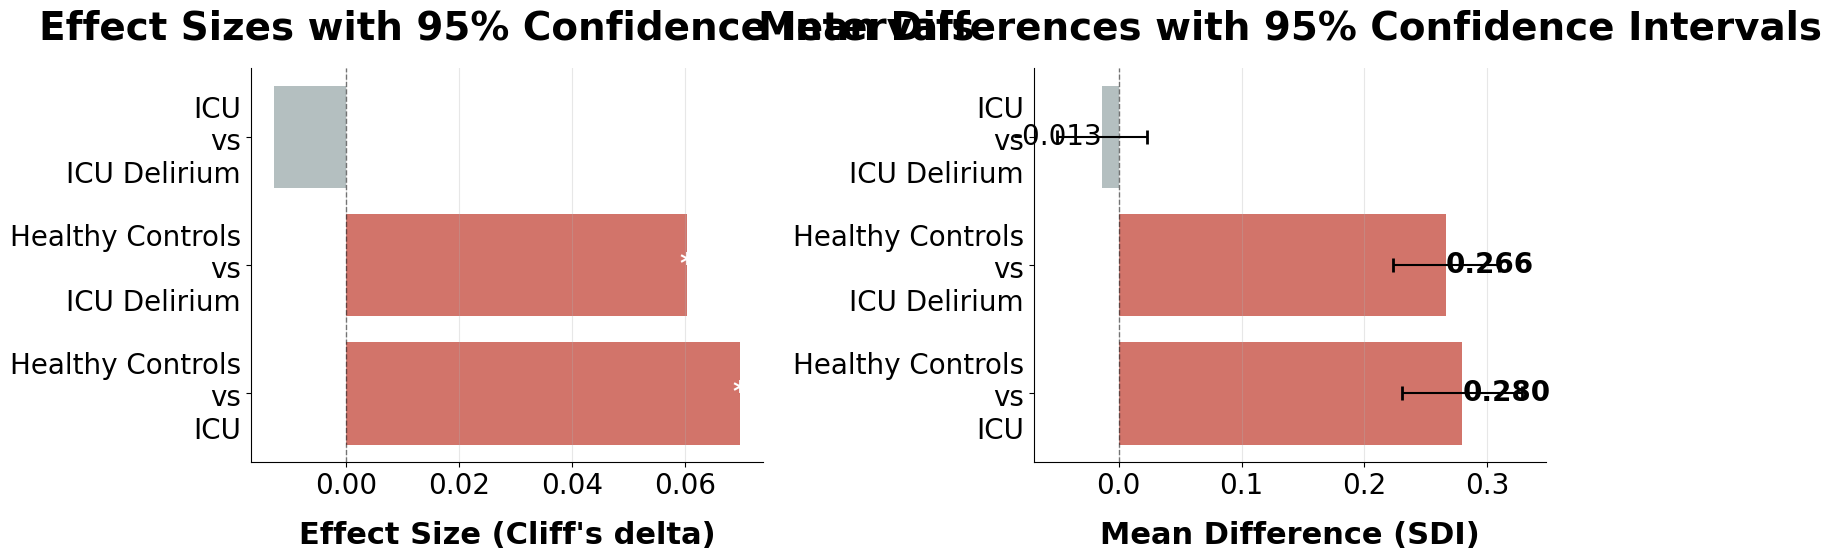


Key Findings:
--------------------------------------------------------------------------------
  ✓ Healthy Controls vs ICU: significant difference
    Effect size: 0.070, Mean diff: 0.280
  ✓ Healthy Controls vs ICU Delirium: significant difference
    Effect size: 0.060, Mean diff: 0.266

  ✗ No significant difference:
    ICU vs ICU Delirium


In [11]:
# Visualize effect sizes with confidence intervals
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Effect sizes with confidence intervals
comparisons = []
effect_sizes = []
ci_lowers = []
ci_uppers = []
significances = []
colors_plot = []

for _, row in posthoc_tests.iterrows():
    g1 = row['group1']
    g2 = row['group2']
    comparisons.append(f"{g1}\nvs\n{g2}")
    effect_sizes.append(row['effect_size'])
    ci_lowers.append(row['effect_size_ci_lower'])
    ci_uppers.append(row['effect_size_ci_upper'])
    significances.append(row['significant'])
    colors_plot.append('#C0392B' if row['significant'] else '#95A5A6')

y_pos = np.arange(len(comparisons))

axes[0].barh(y_pos, effect_sizes, color=colors_plot, alpha=0.7)
axes[0].errorbar(effect_sizes, y_pos, xerr=[np.array(effect_sizes) - np.array(ci_lowers),
                                            np.array(ci_uppers) - np.array(effect_sizes)],
                fmt='none', color='black', capsize=5, capthick=2)

axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(comparisons)
axes[0].set_xlabel("Effect Size (Cliff's delta)", fontweight='bold')
axes[0].set_title("Effect Sizes with 95% Confidence Intervals", fontweight='bold', pad=20)
axes[0].grid(axis='x', alpha=0.3)

# Add significance markers
for i, (sig, effect) in enumerate(zip(significances, effect_sizes)):
    if sig:
        axes[0].text(effect, i, '*', ha='center', va='center', 
                    fontsize=20, fontweight='bold', color='white')

# Plot 2: Mean differences
mean_diffs = posthoc_tests['mean_diff'].values
mean_ci_lowers = posthoc_tests['ci_lower'].values
mean_ci_uppers = posthoc_tests['ci_upper'].values

axes[1].barh(y_pos, mean_diffs, color=colors_plot, alpha=0.7)
axes[1].errorbar(mean_diffs, y_pos, xerr=[np.array(mean_diffs) - np.array(mean_ci_lowers),
                                          np.array(mean_ci_uppers) - np.array(mean_diffs)],
                fmt='none', color='black', capsize=5, capthick=2)

axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(comparisons)
axes[1].set_xlabel("Mean Difference (SDI)", fontweight='bold')
axes[1].set_title("Mean Differences with 95% Confidence Intervals", fontweight='bold', pad=20)
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (diff, sig) in enumerate(zip(mean_diffs, significances)):
    axes[1].text(diff, i, f'{diff:.3f}', ha='left' if diff > 0 else 'right', 
                va='center', fontweight='bold' if sig else 'normal')

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print("-" * 80)
sig_comparisons = posthoc_tests[posthoc_tests['significant'] == True]
for _, row in sig_comparisons.iterrows():
    print(f"  ✓ {row['group1']} vs {row['group2']}: significant difference")
    print(f"    Effect size: {row['effect_size']:.3f}, Mean diff: {row['mean_diff']:.3f}")

ns_comparisons = posthoc_tests[posthoc_tests['significant'] == False]
if len(ns_comparisons) > 0:
    print(f"\n  ✗ No significant difference:")
    for _, row in ns_comparisons.iterrows():
        print(f"    {row['group1']} vs {row['group2']}")


## 6. Regional Analysis

We now examine differences at the regional level, aggregating parcels into 12 brain regions/networks.


In [ ]:
# Display regional statistics
print("=" * 80)
print("REGIONAL STATISTICS")
print("=" * 80)

# Show summary by region
print("\nMean SDI by Region and Group:")
print("-" * 80)

# Pivot table for better visualization
regional_pivot = regional_stats.pivot_table(
    index='region_category', 
    columns='group', 
    values='mean'
).round(3)

display(regional_pivot)

# Show regions with largest differences
print("\nRegions with Largest Mean SDI Differences:")
print("-" * 80)
region_diffs = []
for region in regional_pivot.index:
    hc_mean = regional_pivot.loc[region, 'Healthy Controls']
    icu_mean = regional_pivot.loc[region, 'ICU']
    delirium_mean = regional_pivot.loc[region, 'ICU Delirium']
    
    max_diff = max(abs(hc_mean - icu_mean), 
                   abs(hc_mean - delirium_mean),
                   abs(icu_mean - delirium_mean))
    region_diffs.append((region, max_diff, hc_mean, icu_mean, delirium_mean))

region_diffs.sort(key=lambda x: x[1], reverse=True)
diff_df = pd.DataFrame(region_diffs, columns=['Region', 'Max Difference', 
                                               'HC Mean', 'ICU Mean', 'Delirium Mean'])
display(diff_df.head(10).round(3))


REGIONAL STATISTICS

Mean SDI by Region and Group:
--------------------------------------------------------------------------------


group,Healthy Controls,ICU,ICU Delirium
region_category,,,
Amygdala,1.560,1.357,1.256
Basal Ganglia,1.775,1.237,1.126
Brainstem,1.254,1.383,1.420
Cerebellum,0.951,1.552,1.364
Default Mode,1.666,1.241,1.248
Dorsal Attention,1.064,0.962,1.041
Frontoparietal,1.070,0.979,1.002
Limbic,1.332,1.230,1.244
Other,1.026,0.909,0.867



Regions with Largest Mean SDI Differences:
--------------------------------------------------------------------------------


,Region,Max Difference,HC Mean,ICU Mean,Delirium Mean
0,Thalamus,1.570,3.352,1.822,1.782
1,Basal Ganglia,0.649,1.775,1.237,1.126
2,Cerebellum,0.601,0.951,1.552,1.364
3,Default Mode,0.425,1.666,1.241,1.248
4,Amygdala,0.304,1.560,1.357,1.256
5,Brainstem,0.166,1.254,1.383,1.420
6,Other,0.159,1.026,0.909,0.867
7,Dorsal Attention,0.102,1.064,0.962,1.041
8,Limbic,0.102,1.332,1.230,1.244
9,Frontoparietal,0.091,1.070,0.979,1.002


In [13]:
# Display regional statistical tests
print("=" * 80)
print("REGIONAL STATISTICAL TESTS")
print("=" * 80)

# Sort by p-value
regional_tests_sorted = regional_tests.sort_values('pvalue')
display(regional_tests_sorted)

# Identify significant regions
significant_regions = regional_tests_sorted[regional_tests_sorted['pvalue'] < 0.05]
print(f"\nSignificant Regions (p < 0.05): {len(significant_regions)}")
print("-" * 80)
for _, row in significant_regions.iterrows():
    region = row['region_category']
    pval = row['pvalue']
    stat = row['statistic']
    
    # Determine significance level
    if pval < 0.001:
        sig_level = "***"
    elif pval < 0.01:
        sig_level = "**"
    else:
        sig_level = "*"
    
    print(f"  {sig_level} {region}: p = {pval:.4e}, statistic = {stat:.3f}")

non_sig_regions = regional_tests_sorted[regional_tests_sorted['pvalue'] >= 0.05]
if len(non_sig_regions) > 0:
    print(f"\nNon-significant Regions (p ≥ 0.05): {len(non_sig_regions)}")
    print("-" * 80)
    for _, row in non_sig_regions.iterrows():
        print(f"  {row['region_category']}: p = {row['pvalue']:.4f}")

print("=" * 80)


REGIONAL STATISTICAL TESTS


,region_category,test,statistic,pvalue,n_groups,groups
10,Thalamus,Kruskal-Wallis,229.011013,1.865909e-50,3,"Healthy Controls, ICU, ICU Delirium"
1,Basal Ganglia,Kruskal-Wallis,146.493603,1.546387e-32,3,"Healthy Controls, ICU, ICU Delirium"
12,Visual,Kruskal-Wallis,42.545584,5.772232e-10,3,"Healthy Controls, ICU, ICU Delirium"
3,Cerebellum,Kruskal-Wallis,32.198071,1.019243e-07,3,"Healthy Controls, ICU, ICU Delirium"
0,Amygdala,Kruskal-Wallis,15.763004,3.776654e-04,3,"Healthy Controls, ICU, ICU Delirium"
4,Default Mode,Kruskal-Wallis,15.026891,5.456977e-04,3,"Healthy Controls, ICU, ICU Delirium"
8,Other,Kruskal-Wallis,9.923787,6.999661e-03,3,"Healthy Controls, ICU, ICU Delirium"
6,Frontoparietal,Kruskal-Wallis,9.517857,8.574794e-03,3,"Healthy Controls, ICU, ICU Delirium"
9,Somatomotor,Kruskal-Wallis,9.357394,9.291111e-03,3,"Healthy Controls, ICU, ICU Delirium"
7,Limbic,Kruskal-Wallis,6.603521,3.681829e-02,3,"Healthy Controls, ICU, ICU Delirium"



Significant Regions (p < 0.05): 10
--------------------------------------------------------------------------------
  *** Thalamus: p = 1.8659e-50, statistic = 229.011
  *** Basal Ganglia: p = 1.5464e-32, statistic = 146.494
  *** Visual: p = 5.7722e-10, statistic = 42.546
  *** Cerebellum: p = 1.0192e-07, statistic = 32.198
  *** Amygdala: p = 3.7767e-04, statistic = 15.763
  *** Default Mode: p = 5.4570e-04, statistic = 15.027
  ** Other: p = 6.9997e-03, statistic = 9.924
  ** Frontoparietal: p = 8.5748e-03, statistic = 9.518
  ** Somatomotor: p = 9.2911e-03, statistic = 9.357
  * Limbic: p = 3.6818e-02, statistic = 6.604

Non-significant Regions (p ≥ 0.05): 3
--------------------------------------------------------------------------------
  Dorsal Attention: p = 0.0627
  Brainstem: p = 0.0897
  Ventral Attention: p = 0.6514


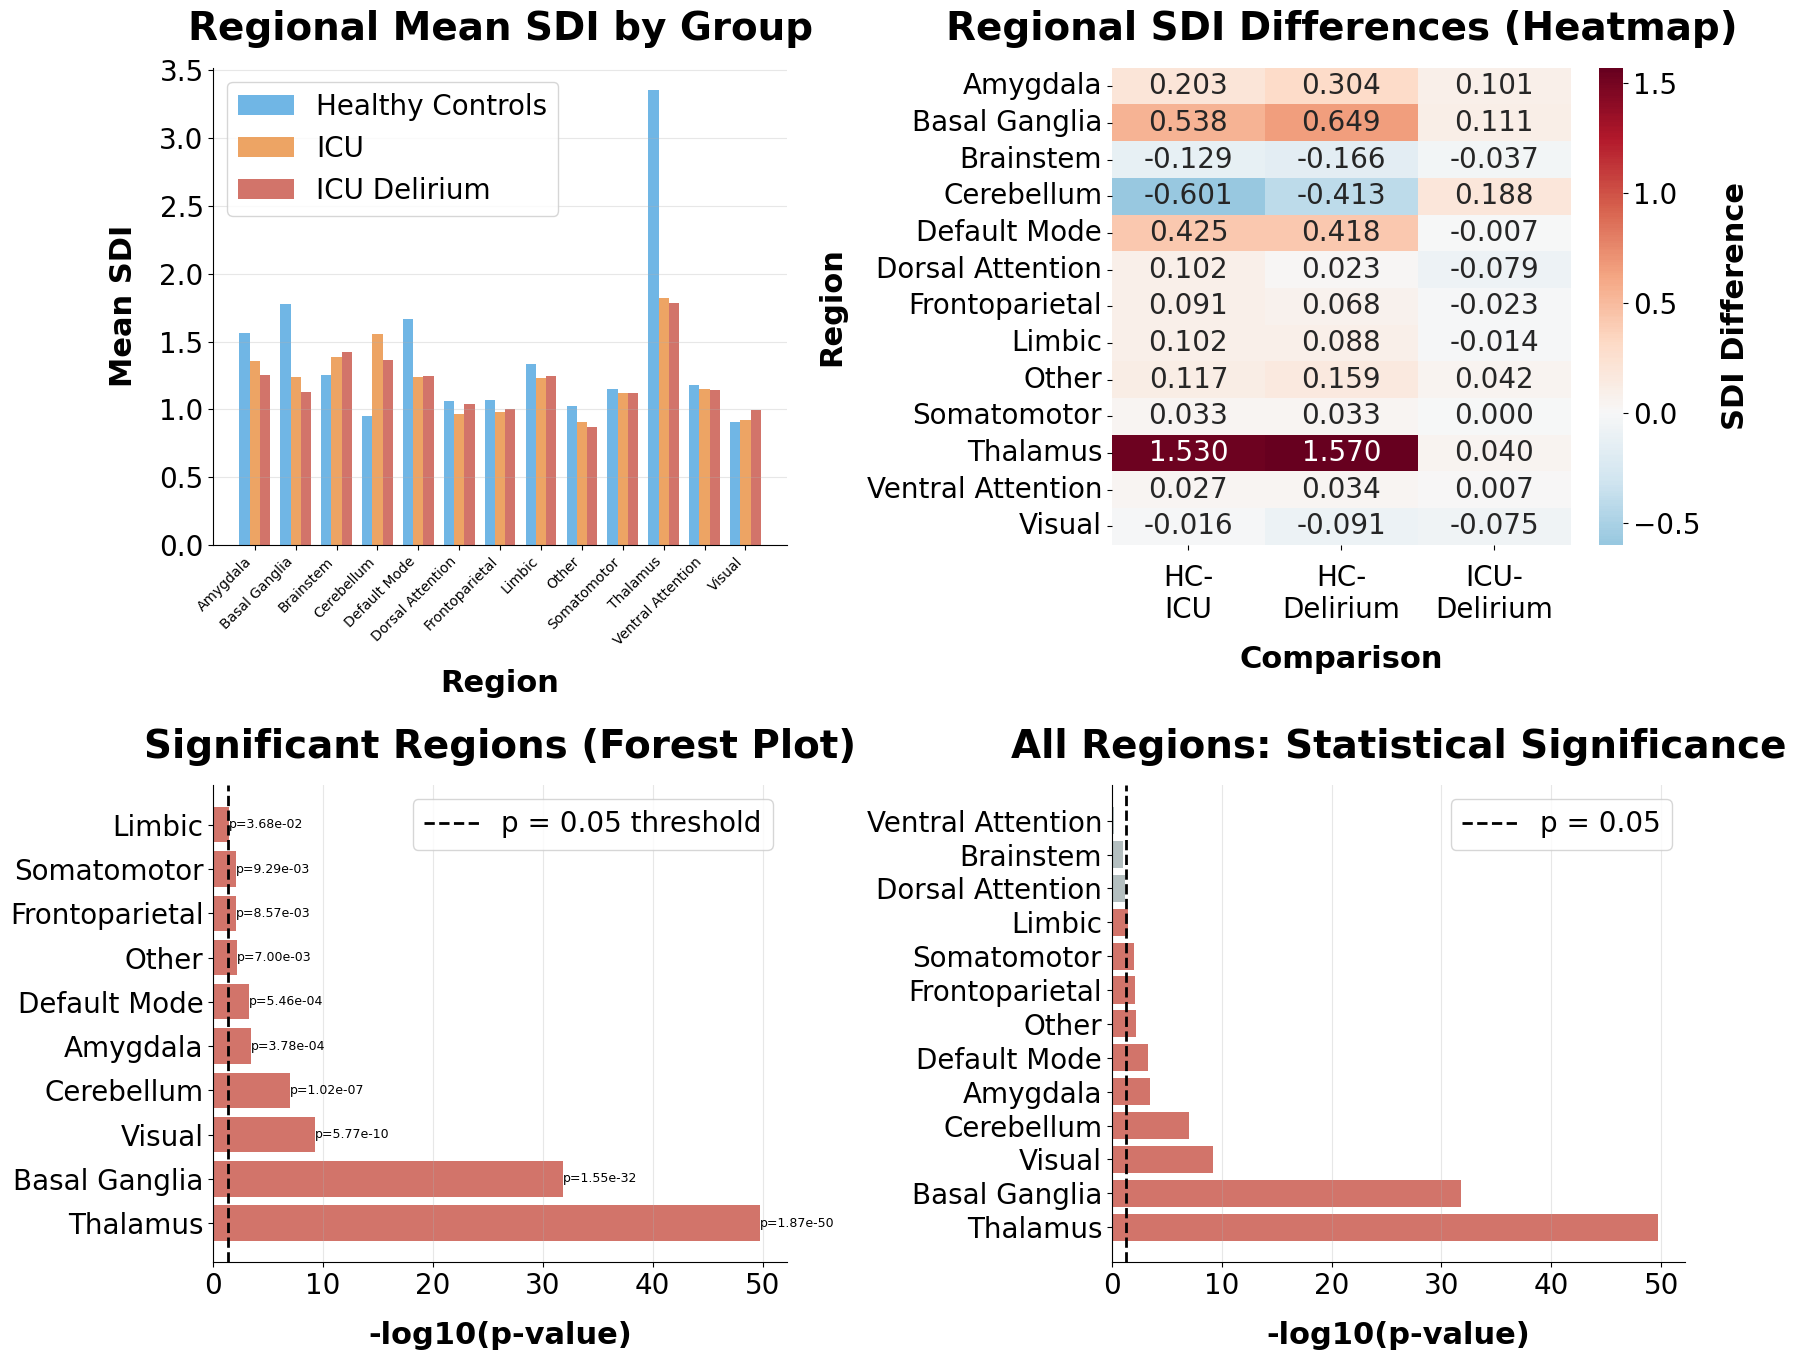


Regional Analysis Summary:
--------------------------------------------------------------------------------
  - Total regions analyzed: 13
  - Significant regions (p < 0.05): 10
  - Most significant region: Thalamus (p = 1.87e-50)
  - Regions with largest mean differences: Thalamus, Basal Ganglia, Cerebellum


In [14]:
# Create comprehensive regional visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Bar plot of regional means by group
regions = regional_pivot.index
x = np.arange(len(regions))
width = 0.25

for i, group in enumerate(['Healthy Controls', 'ICU', 'ICU Delirium']):
    offset = (i - 1) * width
    axes[0, 0].bar(x + offset, regional_pivot[group].values, width, 
                   label=group, color=colors[i], alpha=0.7)

axes[0, 0].set_xlabel('Region', fontweight='bold')
axes[0, 0].set_ylabel('Mean SDI', fontweight='bold')
axes[0, 0].set_title('Regional Mean SDI by Group', fontweight='bold', pad=20)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(regions, rotation=45, ha='right', fontsize=10)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Heatmap of regional differences
# Calculate differences: HC - ICU, HC - Delirium, ICU - Delirium
diff_matrix = pd.DataFrame(index=regions, columns=['HC - ICU', 'HC - Delirium', 'ICU - Delirium'])
for region in regions:
    diff_matrix.loc[region, 'HC - ICU'] = regional_pivot.loc[region, 'Healthy Controls'] - regional_pivot.loc[region, 'ICU']
    diff_matrix.loc[region, 'HC - Delirium'] = regional_pivot.loc[region, 'Healthy Controls'] - regional_pivot.loc[region, 'ICU Delirium']
    diff_matrix.loc[region, 'ICU - Delirium'] = regional_pivot.loc[region, 'ICU'] - regional_pivot.loc[region, 'ICU Delirium']

# Ensure numeric dtype for heatmap
diff_matrix = diff_matrix.astype(float)

sns.heatmap(diff_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            ax=axes[0, 1], cbar_kws={'label': 'SDI Difference'})
# Improve spacing for comparison labels
axes[0, 1].set_xticklabels(['HC-\nICU', 'HC-\nDelirium', 'ICU-\nDelirium'], rotation=0, ha='center')
axes[0, 1].tick_params(axis='x', pad=10)
axes[0, 1].set_title('Regional SDI Differences (Heatmap)', fontweight='bold', pad=20)
axes[0, 1].set_xlabel('Comparison', fontweight='bold')
axes[0, 1].set_ylabel('Region', fontweight='bold')

# Plot 3: Forest plot of regional p-values (-log10)
sig_regions_sorted = significant_regions.sort_values('pvalue')
y_pos = np.arange(len(sig_regions_sorted))
pvals_log = -np.log10(sig_regions_sorted['pvalue'].values)

axes[1, 0].barh(y_pos, pvals_log, color='#C0392B', alpha=0.7)
axes[1, 0].axvline(x=-np.log10(0.05), color='black', linestyle='--', 
                  linewidth=2, label='p = 0.05 threshold')
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(sig_regions_sorted['region_category'].values)
axes[1, 0].set_xlabel('-log10(p-value)', fontweight='bold')
axes[1, 0].set_title('Significant Regions (Forest Plot)', fontweight='bold', pad=20)
axes[1, 0].legend()
axes[1, 0].grid(axis='x', alpha=0.3)

# Add p-value labels
for i, pval in enumerate(sig_regions_sorted['pvalue'].values):
    axes[1, 0].text(-np.log10(pval), i, f'p={pval:.2e}', 
                   ha='left', va='center', fontsize=9)

# Plot 4: Regional effect sizes (if available in regional_tests)
# For now, show p-values as effect size proxy
pvals = regional_tests_sorted['pvalue'].values
regions_ordered = regional_tests_sorted['region_category'].values
y_pos = np.arange(len(regions_ordered))

# Color by significance
colors_plot = ['#C0392B' if p < 0.05 else '#95A5A6' for p in pvals]
axes[1, 1].barh(y_pos, -np.log10(pvals), color=colors_plot, alpha=0.7)
axes[1, 1].axvline(x=-np.log10(0.05), color='black', linestyle='--', 
                  linewidth=2, label='p = 0.05')
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels(regions_ordered)
axes[1, 1].set_xlabel('-log10(p-value)', fontweight='bold')
axes[1, 1].set_title('All Regions: Statistical Significance', fontweight='bold', pad=20)
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRegional Analysis Summary:")
print("-" * 80)
print(f"  - Total regions analyzed: {len(regional_tests)}")
print(f"  - Significant regions (p < 0.05): {len(significant_regions)}")
print(f"  - Most significant region: {significant_regions.iloc[0]['region_category']} (p = {significant_regions.iloc[0]['pvalue']:.2e})")
print(f"  - Regions with largest mean differences: {', '.join(diff_df.head(3)['Region'].values)}")


### Regional Interpretation

**Key Findings:**
- **Thalamus** shows the most dramatic differences (p < 1.87e-50) - this is the most significant finding
- **Basal Ganglia** also highly significant (p < 1.55e-32)
- **Visual network** shows significant differences (p < 5.77e-10)
- **Cerebellum** shows significant differences (p < 1.02e-07)
- Several cortical networks (Default Mode, Frontoparietal, Somatomotor, Limbic) show significant differences
- **Ventral Attention** and **Dorsal Attention** show less significant or non-significant differences

**Patterns:**
- **Subcortical regions** (Thalamus, Basal Ganglia) show the strongest effects
- **Cortical networks** show variable effects, with Visual and Default Mode networks most affected
- **Attention networks** show minimal differences between groups


## 7. Parcel-Level Analysis

We now examine differences at the individual parcel level to identify specific brain areas showing significant changes.


In [ ]:
# Analyze significant parcels
print("=" * 80)
print("PARCEL-LEVEL ANALYSIS")
print("=" * 80)

# Count significant parcels
sig_fdr = significant_parcels_fdr[significant_parcels_fdr['significant'] == True]
sig_bonf = significant_parcels_bonf[significant_parcels_bonf['significant'] == True]

print(f"\nSignificant Parcels:")
print("-" * 80)
print(f"  FDR correction (α = 0.05): {len(sig_fdr)} parcels")
print(f"  Bonferroni correction (α = 0.05): {len(sig_bonf)} parcels")

# Show top significant parcels (FDR)
print(f"\nTop 20 Most Significant Parcels (FDR corrected):")
print("-" * 80)
top_parcels = sig_fdr.nsmallest(20, 'pvalue_corrected')[['parcel_id', 'pvalue', 'pvalue_corrected', 'statistic']]
display(top_parcels.round(6))

# Analyze which regions contain most significant parcels
print(f"\nRegional Distribution of Significant Parcels:")
print("-" * 80)

# Load atlas mapping to get region categories for parcels
from utils.connectome_utils import load_parcellation_mappings, ATLAS_TO_YEO7_CSV
import pandas as pd

atlas_to_yeo7_df = pd.read_csv(ATLAS_TO_YEO7_CSV)
parcel_to_yeo7, parcel_to_category = load_parcellation_mappings()

# Map significant parcels to regions
from utils.connectome_utils import get_region_category_indices

sig_parcel_regions = {}
for parcel_id in sig_fdr['parcel_id'].values:
    region = get_region_category_indices(parcel_id, atlas_to_yeo7_df)
    if region:
        if region not in sig_parcel_regions:
            sig_parcel_regions[region] = 0
        sig_parcel_regions[region] += 1

# Sort by count
region_counts = sorted(sig_parcel_regions.items(), key=lambda x: x[1], reverse=True)
region_counts_df = pd.DataFrame(region_counts, columns=['Region', 'N Significant Parcels'])
display(region_counts_df)

print(f"\nTotal significant parcels: {len(sig_fdr)}")
print(f"Regions with significant parcels: {len(sig_parcel_regions)}")


PARCEL-LEVEL ANALYSIS

Significant Parcels:
--------------------------------------------------------------------------------
  FDR correction (α = 0.05): 161 parcels
  Bonferroni correction (α = 0.05): 63 parcels

Top 20 Most Significant Parcels (FDR corrected):
--------------------------------------------------------------------------------


,parcel_id,pvalue,pvalue_corrected,statistic
10,11,0.000037,0.000354,20.435172
25,26,0.000035,0.000354,20.497701
43,44,0.000037,0.000354,20.403908
53,54,0.000031,0.000354,20.790805
67,68,0.000037,0.000354,20.435172
69,70,0.000035,0.000354,20.540690
70,71,0.000034,0.000354,20.591494
83,84,0.000037,0.000354,20.435172
85,86,0.000033,0.000354,20.650115
88,89,0.000028,0.000354,20.962759



Regional Distribution of Significant Parcels:
--------------------------------------------------------------------------------


,Region,N Significant Parcels
0,Default Mode,34
1,Thalamus,32
2,Visual,18
3,Somatomotor,17
4,Ventral Attention,15
5,Basal Ganglia,13
6,Frontoparietal,12
7,Dorsal Attention,9
8,Limbic,6
9,Amygdala,2



Total significant parcels: 161
Regions with significant parcels: 12


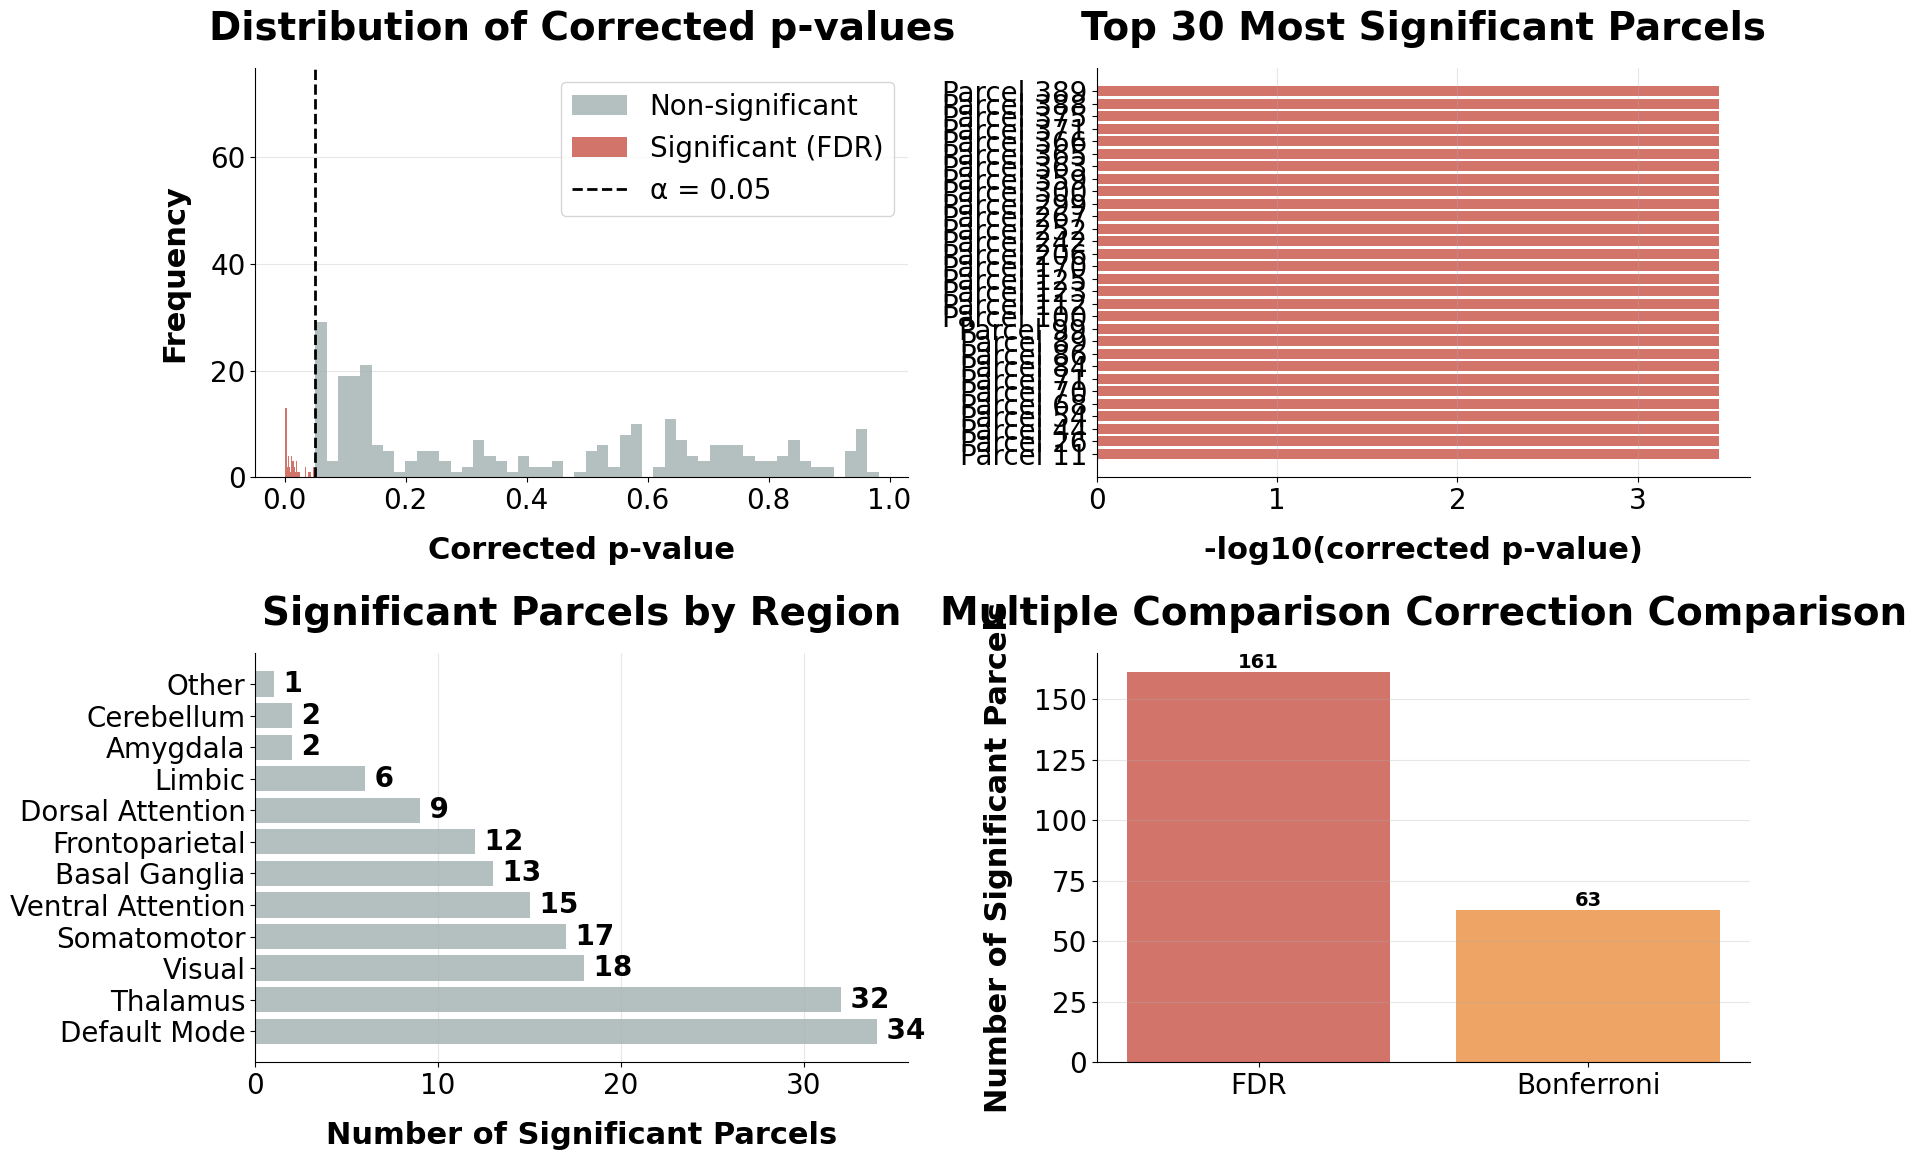


Parcel-Level Summary:
--------------------------------------------------------------------------------
  - Total parcels analyzed: 430
  - Significant parcels (FDR): 161 (37.4%)
  - Significant parcels (Bonferroni): 63 (14.7%)
  - Region with most significant parcels: Default Mode (34 parcels)


In [16]:
# Visualize parcel-level results
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Distribution of p-values (corrected)
all_pvals_corr = significant_parcels_fdr['pvalue_corrected'].astype(float).values
sig_mask = significant_parcels_fdr['significant'].fillna(False).astype(bool).values

axes[0, 0].hist(all_pvals_corr[~sig_mask], bins=50, alpha=0.7,
                label='Non-significant', color='#95A5A6')
axes[0, 0].hist(all_pvals_corr[sig_mask], bins=50, alpha=0.7,
                label='Significant (FDR)', color='#C0392B')
axes[0, 0].axvline(x=0.05, color='black', linestyle='--', linewidth=2,
                   label='α = 0.05')
axes[0, 0].set_xlabel('Corrected p-value', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Distribution of Corrected p-values', fontweight='bold', pad=20)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Top N most significant parcels
top_n = 30
top_parcels_plot = sig_fdr.nsmallest(top_n, 'pvalue_corrected')
y_pos = np.arange(len(top_parcels_plot))

axes[0, 1].barh(y_pos, -np.log10(top_parcels_plot['pvalue_corrected'].values), 
                color='#C0392B', alpha=0.7)
axes[0, 1].set_yticks(y_pos)
axes[0, 1].set_yticklabels([f"Parcel {pid}" for pid in top_parcels_plot['parcel_id'].values])
axes[0, 1].set_xlabel('-log10(corrected p-value)', fontweight='bold')
axes[0, 1].set_title(f'Top {top_n} Most Significant Parcels', fontweight='bold', pad=20)
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Regional distribution of significant parcels
if len(region_counts_df) > 0:
    regions_plot = region_counts_df['Region'].values[:15]  # Top 15 regions
    counts_plot = region_counts_df['N Significant Parcels'].values[:15]
    
    axes[1, 0].barh(range(len(regions_plot)), counts_plot, color='#95A5A6', alpha=0.7)
    axes[1, 0].set_yticks(range(len(regions_plot)))
    axes[1, 0].set_yticklabels(regions_plot)
    axes[1, 0].set_xlabel('Number of Significant Parcels', fontweight='bold')
    axes[1, 0].set_title('Significant Parcels by Region', fontweight='bold', pad=20)
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # Add count labels
    for i, count in enumerate(counts_plot):
        axes[1, 0].text(count, i, f' {count}', va='center', fontweight='bold')

# Plot 4: Comparison of FDR vs Bonferroni
comparison_data = {
    'FDR': len(sig_fdr),
    'Bonferroni': len(sig_bonf)
}

axes[1, 1].bar(comparison_data.keys(), comparison_data.values(), 
               color=['#C0392B', '#E67E22'], alpha=0.7)
axes[1, 1].set_ylabel('Number of Significant Parcels', fontweight='bold')
axes[1, 1].set_title('Multiple Comparison Correction Comparison', fontweight='bold', pad=20)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for method, count in comparison_data.items():
    axes[1, 1].text(method, count, f'{count}', ha='center', va='bottom', 
                   fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

print("\nParcel-Level Summary:")
print("-" * 80)
print(f"  - Total parcels analyzed: {len(significant_parcels_fdr)}")
print(f"  - Significant parcels (FDR): {len(sig_fdr)} ({100*len(sig_fdr)/len(significant_parcels_fdr):.1f}%)")
print(f"  - Significant parcels (Bonferroni): {len(sig_bonf)} ({100*len(sig_bonf)/len(significant_parcels_fdr):.1f}%)")
if len(region_counts_df) > 0:
    print(f"  - Region with most significant parcels: {region_counts_df.iloc[0]['Region']} ({region_counts_df.iloc[0]['N Significant Parcels']} parcels)")


## What each analysis tests
- Regional analysis: Aggregates parcels into coarse brain regions (e.g., Thalamus, Basal Ganglia, Default Mode, etc.) and runs a Kruskal–Wallis across groups on the region-level SDI values. It asks: “Does the distribution of SDI differ between groups for this region as a whole?” Effect is driven by the average SDI and the variability within that region category.
- Parcel-level analysis: Tests each individual parcel separately with Kruskal–Wallis (then FDR/Bonferroni). It asks: “Which specific parcels differ between groups?” This can highlight parcels even if the broader region is heterogeneous.


Thalamus: Broad, consistent group differences in structural–functional coupling (SDI), suggesting a systemic subcortical effect tied to delirium/ICU status.
Default Mode parcels: Specific cortical nodes show strong differences, indicating focal cortical alterations, but the network as a whole is more heterogeneous, hence the parcel-level hits without the region topping the list.
Together: The findings suggest both widespread subcortical coupling changes (Thalamus) and focal cortical alterations (notably within Default Mode parcels). The regional view emphasizes coherent region-wide changes; the parcel view pinpoints the most affected individual sites.

## 8. Structural Coupling Analysis (Low SDI Regions)

**Key Concept:** Low SDI = High structural coupling (functional signal aligned with structural connectivity)

We identify regions with the lowest SDI values, indicating highest structural coupling.


In [19]:
# Identify high coupling regions (low SDI)
print("=" * 80)
print("STRUCTURAL COUPLING ANALYSIS")
print("=" * 80)

# Calculate mean SDI per region across all groups
region_means_all = regional_stats.groupby('region_category')['mean'].mean().sort_values()
region_stds_all = regional_stats.groupby('region_category')['std'].mean().sort_values()

print("\nRegions Ranked by Mean SDI (Lowest = Highest Coupling):")
print("-" * 80)
coupling_rank = pd.DataFrame({
    'Mean SDI (All Groups)': region_means_all.values,
    'Std SDI (All Groups)': region_stds_all.values
}, index=region_means_all.index)
display(coupling_rank.round(3))

print("\nTop 5 Regions with Highest Structural Coupling (Lowest SDI):")
print("-" * 80)
top_coupling = coupling_rank.head(5)
for i, (region, row) in enumerate(top_coupling.iterrows(), 1):
    print(f"{i}. {region}: SDI = {row['Mean SDI (All Groups)']:.3f} ± {row['Std SDI (All Groups)']:.3f}")
print("\nBottom 5 Regions with Lowest Structural Coupling (Highest SDI):")
print("-" * 80)
bottom_coupling = coupling_rank.tail(5)
for i, (region, row) in enumerate(list(bottom_coupling.iterrows())[::-1], 1):
    print(f"{i}. {region}: SDI = {row['Mean SDI (All Groups)']:.3f} ± {row['Std SDI (All Groups)']:.3f}")

STRUCTURAL COUPLING ANALYSIS

Regions Ranked by Mean SDI (Lowest = Highest Coupling):
--------------------------------------------------------------------------------


,Mean SDI (All Groups),Std SDI (All Groups)
region_category,,
Other,0.934,0.124
Visual,0.941,0.238
Frontoparietal,1.017,0.243
Dorsal Attention,1.022,0.351
Somatomotor,1.130,0.356
Ventral Attention,1.156,0.376
Limbic,1.269,0.466
Cerebellum,1.289,0.516
Brainstem,1.352,0.598



Top 5 Regions with Highest Structural Coupling (Lowest SDI):
--------------------------------------------------------------------------------
1. Other: SDI = 0.934 ± 0.124
2. Visual: SDI = 0.941 ± 0.238
3. Frontoparietal: SDI = 1.017 ± 0.243
4. Dorsal Attention: SDI = 1.022 ± 0.351
5. Somatomotor: SDI = 1.130 ± 0.356

Bottom 5 Regions with Lowest Structural Coupling (Highest SDI):
--------------------------------------------------------------------------------
1. Thalamus: SDI = 2.319 ± 1.903
2. Amygdala: SDI = 1.391 ± 1.057
3. Default Mode: SDI = 1.385 ± 0.626
4. Basal Ganglia: SDI = 1.379 ± 0.624
5. Brainstem: SDI = 1.352 ± 0.598


In [20]:
# Analyze coupling patterns by group
print("\nCoupling Patterns by Group:")
print("-" * 80)

# For each group, identify regions with lowest SDI
for group in ['Healthy Controls', 'ICU', 'ICU Delirium']:
    group_regional = regional_stats[regional_stats['group'] == group].sort_values('mean')
    print(f"\n{group} - Top 5 Most Coupled Regions:")
    for i, (_, row) in enumerate(group_regional.head(5).iterrows(), 1):
        print(f"  {i}. {row['region_category']}: SDI = {row['mean']:.3f}")

# Calculate coupling differences between groups
print("\nCoupling Differences (HC - ICU groups):")
print("-" * 80)
hc_regional = regional_stats[regional_stats['group'] == 'Healthy Controls'].set_index('region_category')['mean']
icu_regional = regional_stats[regional_stats['group'] == 'ICU'].set_index('region_category')['mean']
delirium_regional = regional_stats[regional_stats['group'] == 'ICU Delirium'].set_index('region_category')['mean']

coupling_diffs = pd.DataFrame({
    'HC - ICU': hc_regional - icu_regional,
    'HC - Delirium': hc_regional - delirium_regional,
    'ICU - Delirium': icu_regional - delirium_regional
}).sort_values('HC - Delirium', ascending=False)

print("\nRegions where HC shows MORE coupling than ICU groups (negative difference = HC more coupled):")
print("-" * 80)
display(coupling_diffs.head(10).round(3))

print("\nRegions where HC shows LESS coupling than ICU groups:")
print("-" * 80)
display(coupling_diffs.tail(10).round(3))



Coupling Patterns by Group:
--------------------------------------------------------------------------------

Healthy Controls - Top 5 Most Coupled Regions:
  1. Visual: SDI = 0.905
  2. Cerebellum: SDI = 0.951
  3. Other: SDI = 1.026
  4. Dorsal Attention: SDI = 1.064
  5. Frontoparietal: SDI = 1.070

ICU - Top 5 Most Coupled Regions:
  1. Other: SDI = 0.909
  2. Visual: SDI = 0.921
  3. Dorsal Attention: SDI = 0.962
  4. Frontoparietal: SDI = 0.979
  5. Somatomotor: SDI = 1.119

ICU Delirium - Top 5 Most Coupled Regions:
  1. Other: SDI = 0.867
  2. Visual: SDI = 0.996
  3. Frontoparietal: SDI = 1.002
  4. Dorsal Attention: SDI = 1.041
  5. Somatomotor: SDI = 1.119

Coupling Differences (HC - ICU groups):
--------------------------------------------------------------------------------

Regions where HC shows MORE coupling than ICU groups (negative difference = HC more coupled):
--------------------------------------------------------------------------------


,HC - ICU,HC - Delirium,ICU - Delirium
region_category,,,
Thalamus,1.530,1.570,0.041
Basal Ganglia,0.538,0.650,0.112
Default Mode,0.425,0.418,-0.007
Amygdala,0.204,0.305,0.101
Other,0.117,0.160,0.043
Limbic,0.102,0.088,-0.014
Frontoparietal,0.091,0.068,-0.023
Ventral Attention,0.027,0.034,0.007
Somatomotor,0.033,0.033,0.000



Regions where HC shows LESS coupling than ICU groups:
--------------------------------------------------------------------------------


,HC - ICU,HC - Delirium,ICU - Delirium
region_category,,,
Amygdala,0.204,0.305,0.101
Other,0.117,0.160,0.043
Limbic,0.102,0.088,-0.014
Frontoparietal,0.091,0.068,-0.023
Ventral Attention,0.027,0.034,0.007
Somatomotor,0.033,0.033,0.000
Dorsal Attention,0.102,0.022,-0.080
Visual,-0.015,-0.090,-0.075
Brainstem,-0.129,-0.166,-0.037


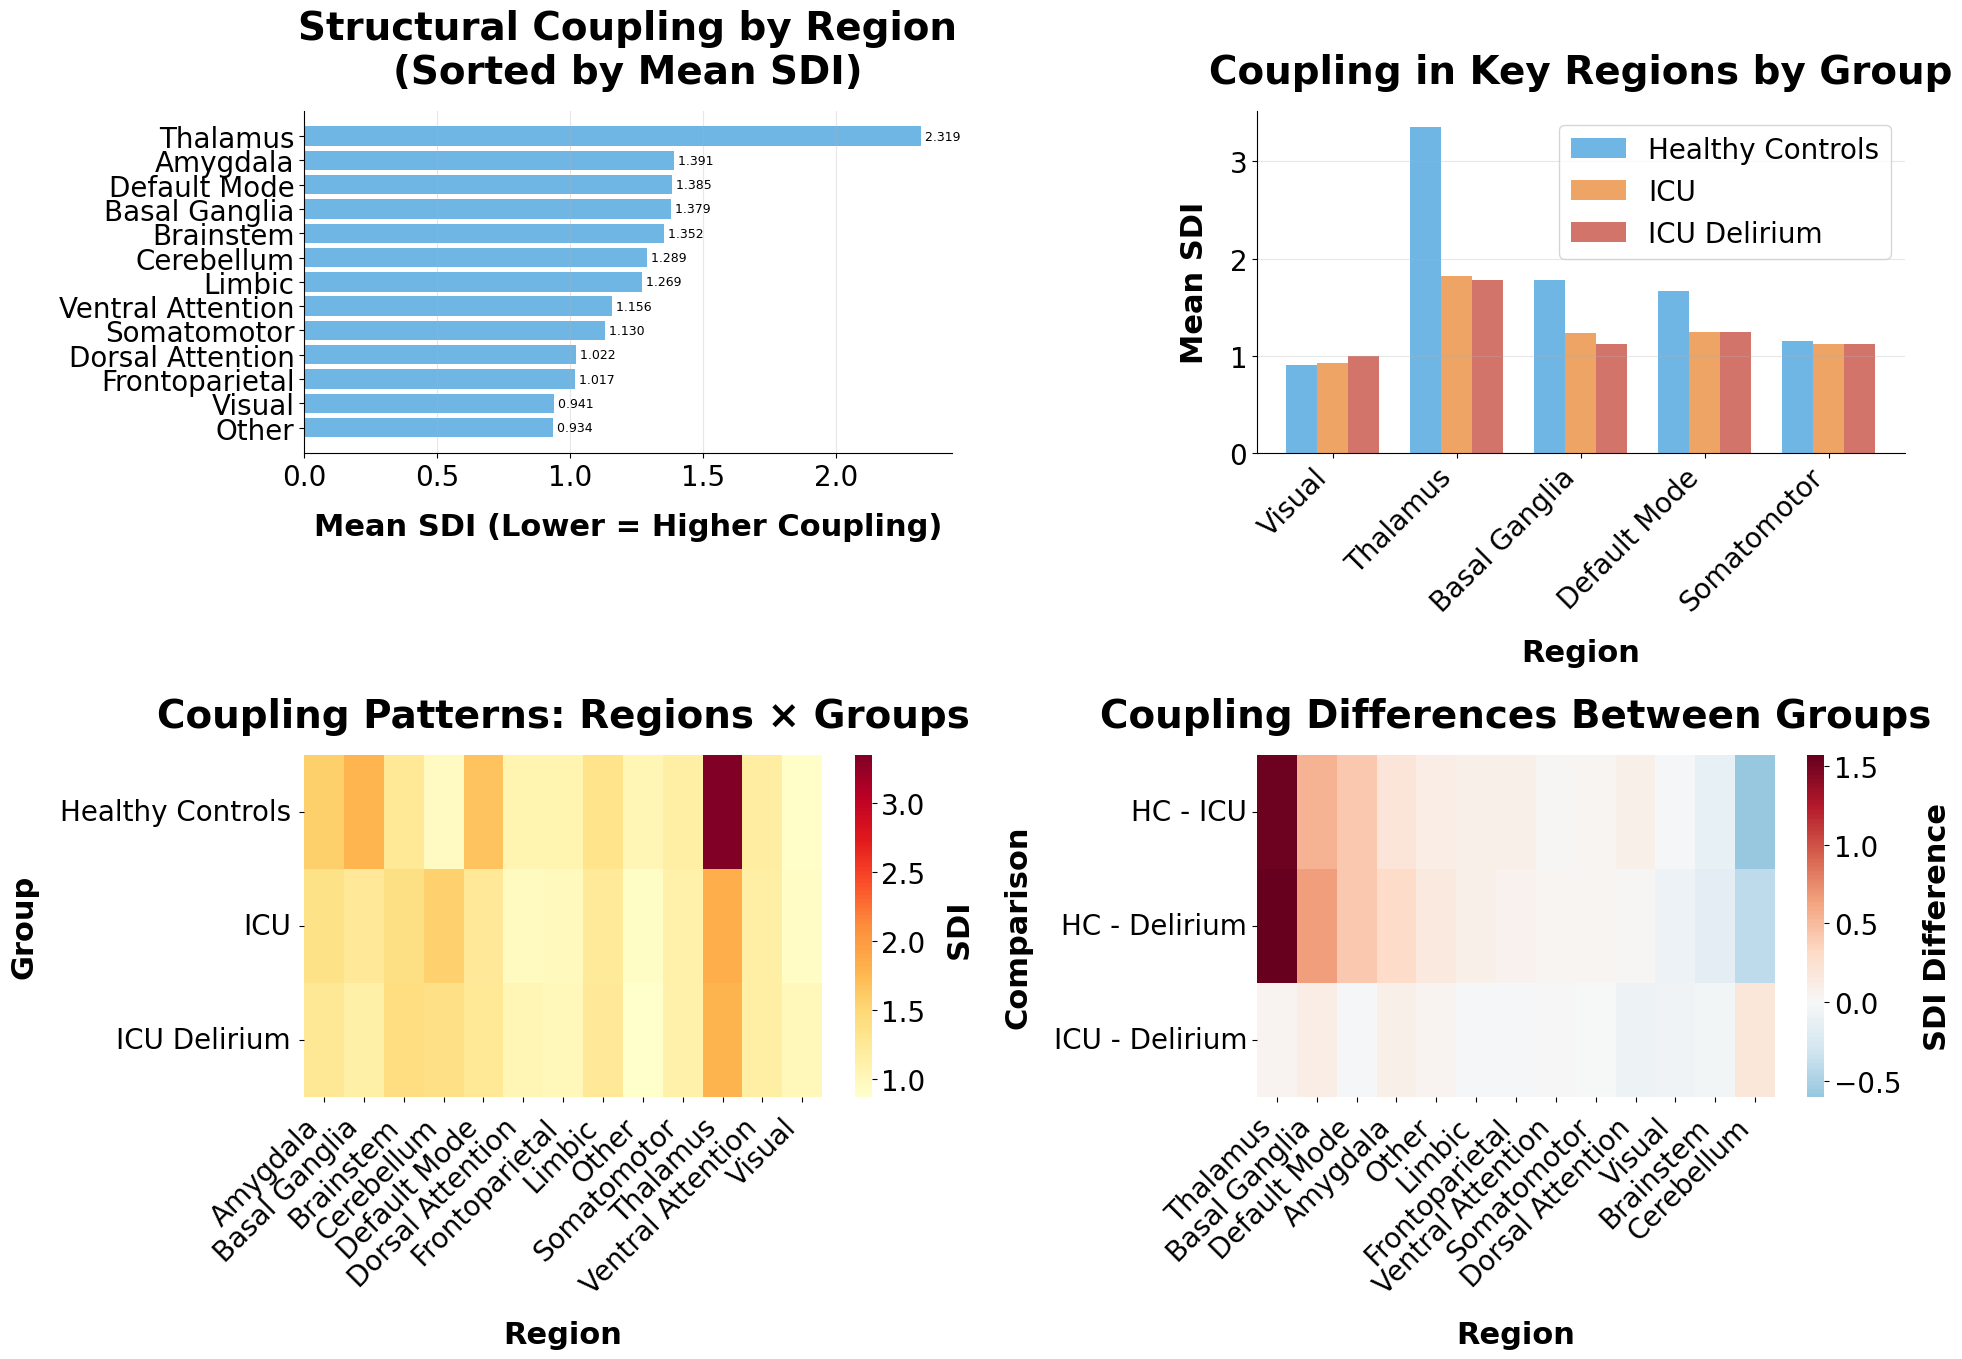


Coupling Analysis Summary:
--------------------------------------------------------------------------------
  - Most coupled region (lowest SDI): Other (SDI = 0.934)
  - Least coupled region (highest SDI): Thalamus (SDI = 2.319)
  - Regions showing altered coupling in delirium: See heatmap above


In [27]:
# Create comprehensive coupling visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Plot 1: Bar plot of mean SDI by region (sorted, all groups)
regions_sorted = coupling_rank.index
means_sorted = coupling_rank['Mean SDI (All Groups)'].values

axes[0, 0].barh(range(len(regions_sorted)), means_sorted, color='#3498DB', alpha=0.7)
axes[0, 0].set_yticks(range(len(regions_sorted)))
axes[0, 0].set_yticklabels(regions_sorted)
axes[0, 0].set_xlabel('Mean SDI (Lower = Higher Coupling)', fontweight='bold')
axes[0, 0].set_title('Structural Coupling by Region\n(Sorted by Mean SDI)', fontweight='bold', pad=20)
axes[0, 0].grid(axis='x', alpha=0.3)

# Add value labels
for i, mean_val in enumerate(means_sorted):
    axes[0, 0].text(mean_val, i, f' {mean_val:.3f}', va='center', fontsize=9)

# Plot 2: Group comparison of coupling in key regions
key_regions = ['Visual', 'Thalamus', 'Basal Ganglia', 'Default Mode', 'Somatomotor']
key_regional_data = regional_stats[regional_stats['region_category'].isin(key_regions)]

x = np.arange(len(key_regions))
width = 0.25

for i, group in enumerate(['Healthy Controls', 'ICU', 'ICU Delirium']):
    group_data = key_regional_data[key_regional_data['group'] == group]
    means = [group_data[group_data['region_category'] == r]['mean'].values[0] 
             if len(group_data[group_data['region_category'] == r]) > 0 else 0 
             for r in key_regions]
    offset = (i - 1) * width
    axes[0, 1].bar(x + offset, means, width, label=group, color=colors[i], alpha=0.7)

axes[0, 1].set_xlabel('Region', fontweight='bold')
axes[0, 1].set_ylabel('Mean SDI', fontweight='bold')
axes[0, 1].set_title('Coupling in Key Regions by Group', fontweight='bold', pad=20)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(key_regions, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)


# Plot 3: Heatmap of coupling patterns
sns.heatmap(
    coupling_matrix, annot=False, fmt='.2f', cmap='YlOrRd',
    ax=axes[1, 0], cbar_kws={'label': 'SDI '}
)
axes[1, 0].set_title('Coupling Patterns: Regions × Groups', fontweight='bold', pad=20)
axes[1, 0].set_xlabel('Region', fontweight='bold')
axes[1, 0].set_ylabel('Group', fontweight='bold')
axes[1, 0].tick_params(axis='x', pad=8)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
axes[1, 0].set_yticklabels(axes[1, 0].get_yticklabels(), rotation=0, ha='right')
axes[1, 0].tick_params(axis='y', pad=6)

# Plot 4: Coupling differences heatmap
sns.heatmap(
    coupling_diffs.T, annot=False, fmt='.3f', cmap='RdBu_r', center=0,
    ax=axes[1, 1], cbar_kws={'label': 'SDI Difference'}
)
axes[1, 1].set_title('Coupling Differences Between Groups', fontweight='bold', pad=20)
axes[1, 1].set_xlabel('Region', fontweight='bold')
axes[1, 1].set_ylabel('Comparison', fontweight='bold')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].tick_params(axis='x', pad=8)

plt.tight_layout()
plt.show()

print("\nCoupling Analysis Summary:")
print("-" * 80)
print(f"  - Most coupled region (lowest SDI): {coupling_rank.index[0]} (SDI = {coupling_rank.iloc[0]['Mean SDI (All Groups)']:.3f})")
print(f"  - Least coupled region (highest SDI): {coupling_rank.index[-1]} (SDI = {coupling_rank.iloc[-1]['Mean SDI (All Groups)']:.3f})")
print(f"  - Regions showing altered coupling in delirium: See heatmap above")


### Coupling Interpretation

**Key Findings:**
1. **Visual network** shows the highest structural coupling (lowest SDI) across all groups
2. **Thalamus** shows very high SDI (low coupling) in Healthy Controls but lower SDI (higher coupling) in ICU groups
3. **Basal Ganglia** shows similar pattern - higher coupling in ICU groups
4. **Default Mode Network** shows moderate coupling across all groups
5. **Cerebellum** shows relatively high coupling (low SDI)

**Clinical Implications:**
- ICU patients (with and without delirium) show **increased structural coupling** in subcortical regions (Thalamus, Basal Ganglia)
- This suggests their functional activity is more constrained by structural connectivity
- Healthy Controls show more **functional decoupling** in these regions, allowing for more flexible functional dynamics
- The Visual network maintains high coupling across all groups, suggesting it's inherently structurally constrained



## 9. Subject × Subject SDI Similarity Analysis

We now examine similarity patterns between subjects' SDI values across different brain regions.
This analysis computes Pearson correlations between subjects' SDI values for each region category,
similar to the structural connectome similarity analysis.


In [ ]:
# Load SDI data manually
# Path to SDI file 
sdi_dir = notebook_dir.parents[2]  
sdi_file_path = sdi_dir / 'SDI_HC_ICU' / 'bandpass' / 'SDI_HC_ICU_bandpass.h5'

# Alternative location if file is in results/SDI_HC_ICU:
# sdi_file_path = sdi_dir / 'results' / 'SDI_HC_ICU' / 'bandpass' / 'SDI_HC_ICU_bandpass.h5'

if not sdi_file_path.exists():
    # Try alternative location
    alt_path = sdi_dir / 'results' / 'SDI_HC_ICU' / 'bandpass' / 'SDI_HC_ICU_bandpass.h5'
    if alt_path.exists():
        sdi_file_path = alt_path
        print(f"Using alternative path: {sdi_file_path}")
    else:
        raise FileNotFoundError(f"SDI file not found. Tried:\n  {sdi_file_path}\n  {alt_path}")

print(f"Loading SDI data from: {sdi_file_path}")

# Load the SDI data
df_wide = pd.read_hdf(sdi_file_path, key='SDI')

# Verify structure
if df_wide.shape[0] != 430:
    raise ValueError(f"Expected 430 parcels, got {df_wide.shape[0]}")

# Get subject IDs from columns
subject_ids = df_wide.columns.tolist()
print(f"Found {len(subject_ids)} subjects")

# Load group assignments from config
from utils.group import load_group_assignments
group_results = load_group_assignments('subjects_underscore', config)

# Map internal group names to standard names
GROUP_NAME_MAPPING = {
    'CR': 'ICU',
    'Delirium': 'ICU Delirium',
    'HC': 'Healthy Controls'
}

# Create unified DataFrame
all_rows = []
for std_group_name, internal_group_name in [('ICU', 'CR'), ('ICU Delirium', 'Delirium'), ('Healthy Controls', 'HC')]:
    if internal_group_name not in group_results:
        continue
    
    # Get subjects for this group (in underscore format)
    group_subjects_underscore = group_results[internal_group_name]
    
    # Convert to hyphen format and match with SDI file columns
    group_subjects_in_data = []
    for s in group_subjects_underscore:
        s_hyphen = s.replace('_', '-')
        # Try to find matching subject ID in SDI file
        for sid in subject_ids:
            if sid.replace('-', '_') == s or sid == s_hyphen or sid.replace('-', '_') == s.replace('_', '-'):
                group_subjects_in_data.append(sid)
                break
    
    print(f"{std_group_name}: {len(group_subjects_in_data)} subjects")
    
    # Extract data for each subject
    for subject_id in group_subjects_in_data:
        subject_data = df_wide[subject_id].values
        
        # Create rows for this subject (parcels are 1-indexed in the output)
        for parcel_id in range(1, 431):
            all_rows.append({
                'subject_id': subject_id,
                'parcel_id': parcel_id,
                'sdi_value': subject_data[parcel_id - 1],  # Convert to 0-indexed
                'group': std_group_name
            })

# Create unified DataFrame
unified_sdi_df = pd.DataFrame(all_rows)

print(f"\n✓ Loaded SDI data: {len(unified_sdi_df)} rows")
print(f"  Groups: {unified_sdi_df['group'].unique()}")
print(f"  Subjects per group:")
for group in unified_sdi_df['group'].unique():
    n_subjects = unified_sdi_df[unified_sdi_df['group'] == group]['subject_id'].nunique()
    print(f"    {group}: {n_subjects} subjects")

Using alternative path: /media/RCPNAS/Data/Delirium/Delirium_Rania/github/SDI_delirium/results/SDI_HC_ICU/bandpass/SDI_HC_ICU_bandpass.h5
Loading SDI data from: /media/RCPNAS/Data/Delirium/Delirium_Rania/github/SDI_delirium/results/SDI_HC_ICU/bandpass/SDI_HC_ICU_bandpass.h5


Found 29 subjects
ICU: 5 subjects
ICU Delirium: 12 subjects
Healthy Controls: 12 subjects

✓ Loaded SDI data: 12470 rows
  Groups: ['ICU' 'ICU Delirium' 'Healthy Controls']
  Subjects per group:
    ICU: 5 subjects
    ICU Delirium: 12 subjects
    Healthy Controls: 12 subjects


In [4]:
import importlib
import utils.connectome_utils
importlib.reload(utils.connectome_utils)

from utils.connectome_utils import (
    compute_sdi_similarity_between_subjects,
    plot_sdi_fingerprint_btw_subjects_by_group,
    ATLAS_TO_YEO7_CSV
)

In [5]:
# Define groups dictionary from unified_sdi_df
# Extract subject IDs for each group
GROUPS_SDI_SIM = {}
if unified_sdi_df is not None:
    for group_name in unified_sdi_df['group'].unique():
        # Get unique subject IDs for this group
        group_subjects = unified_sdi_df[unified_sdi_df['group'] == group_name]['subject_id'].unique()
        # Ensure subject IDs have 'sub-' prefix
        subject_list = []
        for subj_id in group_subjects:
            if not subj_id.startswith('sub-'):
                subject_list.append(f"sub-{subj_id}")
            else:
                subject_list.append(subj_id)
        GROUPS_SDI_SIM[group_name] = sorted(subject_list)
    
    print("Groups for SDI similarity analysis:")
    for group_name, subjects in GROUPS_SDI_SIM.items():
        print(f"  {group_name}: {len(subjects)} subjects")
else:
    print("Warning: unified_sdi_df not available. Please load SDI data first.")
    GROUPS_SDI_SIM = None

# Define region categories - use network names that match get_region_category_indices output
REGION_CATEGORIES = ['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 
                    'Limbic', 'Frontoparietal', 'Default Mode',
                    'Thalamus', 'Amygdala', 'Basal Ganglia', 'Other',
                    'Brainstem', 'Cerebellum']
print(f"\nRegion categories: {len(REGION_CATEGORIES)} regions")


Groups for SDI similarity analysis:
  ICU: 5 subjects
  ICU Delirium: 12 subjects
  Healthy Controls: 12 subjects

Region categories: 13 regions


In [6]:
# Compute SDI similarity between subjects
if unified_sdi_df is not None and GROUPS_SDI_SIM is not None:
    # Set save path for similarity matrices
    similarity_save_path = results_dir / 'sdi_similarity_matrices_bandpass.h5'
    
    # Compute similarity matrices
    similarity_df = compute_sdi_similarity_between_subjects(
        unified_sdi_df=unified_sdi_df,
        groups=GROUPS_SDI_SIM,
        overwrite=False,  # Set to True to recompute
        save_path=similarity_save_path
    )
    
    print(f"\n✓ Computed similarity matrices")
    print(f"  Total pairs: {len(similarity_df)}")
    print(f"  Groups: {similarity_df['Group'].unique()}")
    print(f"  Regions: {similarity_df['Region Category'].unique()}")
else:
    print("Skipping similarity computation: SDI data or groups not available")
    similarity_df = None


Loading existing similarity matrices from /media/RCPNAS/Data/Delirium/Delirium_Rania/github/SDI_delirium/results/analysis/sdi_similarity_matrices_bandpass.h5

✓ Computed similarity matrices
  Total pairs: 1846
  Groups: ['ICU' 'ICU Delirium' 'Healthy Controls']
  Regions: ['Visual' 'Somatomotor' 'Dorsal Attention' 'Ventral Attention' 'Limbic'
 'Frontoparietal' 'Default Mode' 'Thalamus' 'Amygdala' 'Basal Ganglia'
 'Other' 'Brainstem' 'Cerebellum']


 Saved figure to /media/RCPNAS/Data/Delirium/Delirium_Rania/github/SDI_delirium/results/analysis/figures/sdi_subject_similarity_bandpass.png


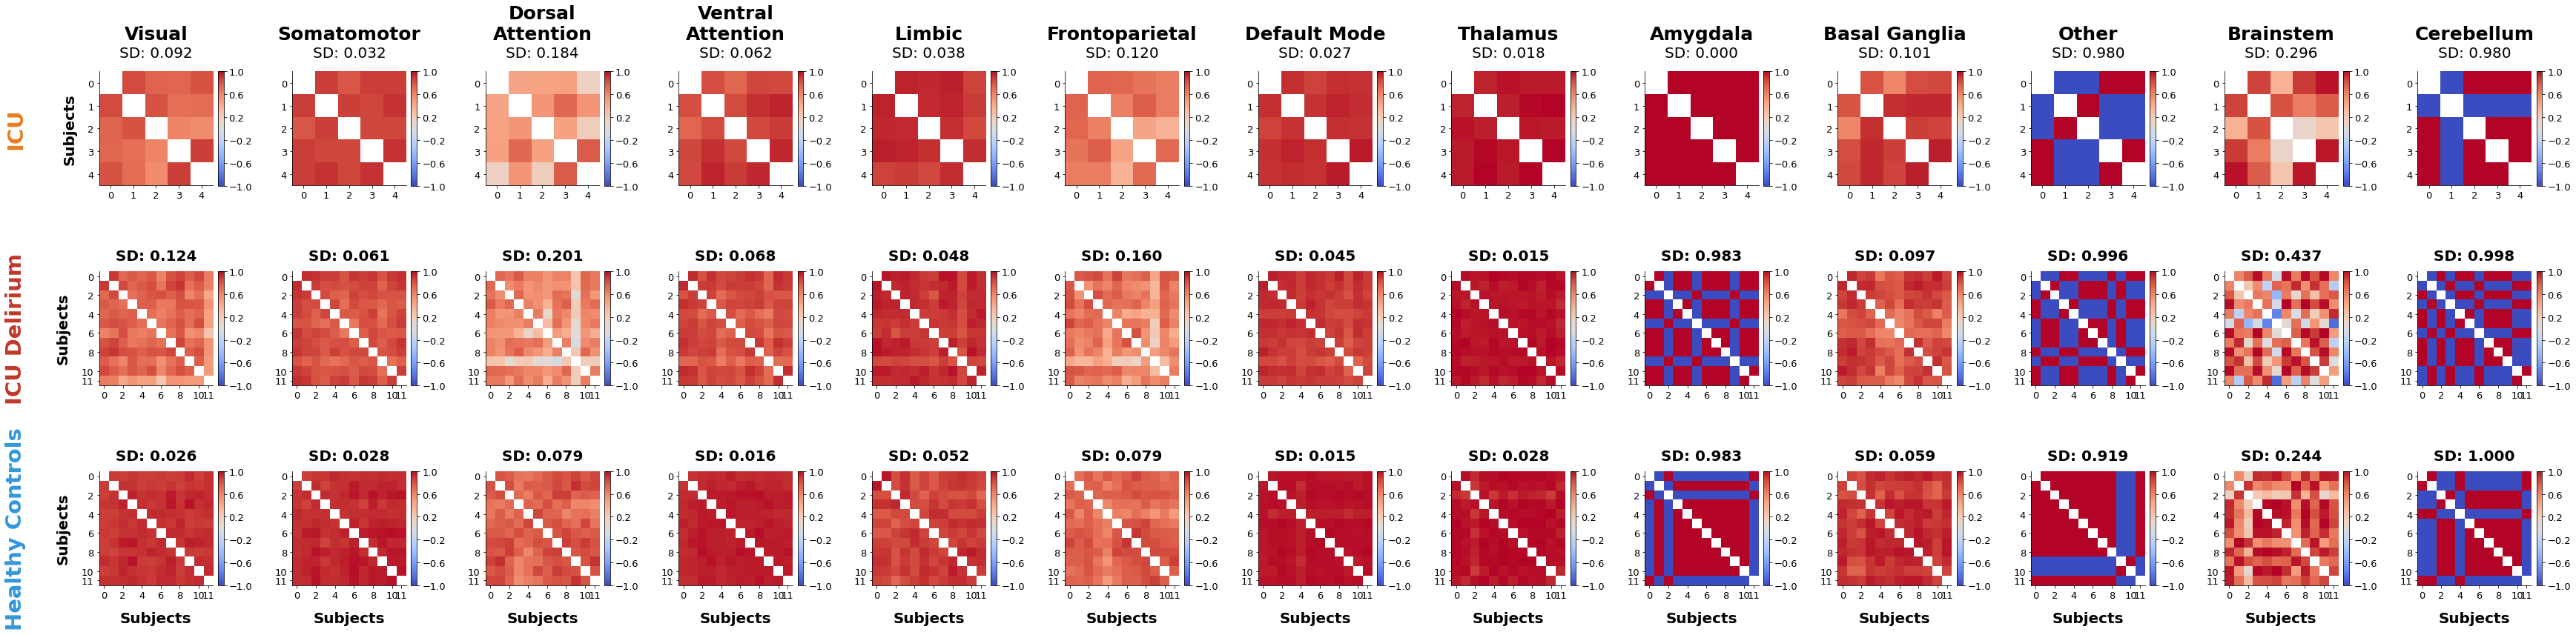

✓ Figure saved to /media/RCPNAS/Data/Delirium/Delirium_Rania/github/SDI_delirium/results/analysis/figures/sdi_subject_similarity_bandpass.png


In [ ]:
# Plot subject × subject similarity matrices
# Layout: Groups as rows, region categories as columns
if similarity_df is not None and GROUPS_SDI_SIM is not None:
    save_path_fig = figures_dir / 'sdi_subject_similarity_bandpass.png'
    
    plot_sdi_fingerprint_btw_subjects_by_group(
        similarity_df=similarity_df,
        groups=GROUPS_SDI_SIM,
        region_categories=REGION_CATEGORIES,
        save_path=save_path_fig,
        scale='same',  # 'bygroup', 'same', or 'auto'
        add_sd=True  # Add standard deviation to subplot titles
    )
    plt.show()
    print(f"✓ Figure saved to {save_path_fig}")
else:
    print("Skipping plot: similarity data not available")


### 10.2 Individual Differences and Heterogeneity Analysis

This analysis examines:
- **Within-subject variability**: How variable is SDI across parcels for each subject?
- **Between-group heterogeneity**: Are some groups more heterogeneous than others?
- **Individual SDI profiles**: What are the characteristic patterns for each subject?

In [10]:
#Individual differences analysis
if unified_sdi_df is not None:
    try:
        from scipy.stats import levene
        
        # Compute coefficient of variation (CV) per subject
        subject_stats = []
        for subject_id in unified_sdi_df['subject_id'].unique():
            subj_data = unified_sdi_df[unified_sdi_df['subject_id'] == subject_id]['sdi_value'].values
            subj_data_clean = subj_data[np.isfinite(subj_data)]
            
            if len(subj_data_clean) > 0:
                mean_val = np.mean(subj_data_clean)
                std_val = np.std(subj_data_clean)
                cv = std_val / mean_val if mean_val > 0 else np.nan
                
                group = unified_sdi_df[unified_sdi_df['subject_id'] == subject_id]['group'].iloc[0]
                
                subject_stats.append({
                    'subject_id': subject_id,
                    'group': group,
                    'mean_sdi': mean_val,
                    'std_sdi': std_val,
                    'cv': cv,
                    'n_parcels': len(subj_data_clean)
                })
        
        subject_stats_df = pd.DataFrame(subject_stats)
        
        print("Subject-level Statistics:")
        print("=" * 80)
        display(subject_stats_df.groupby('group')[['mean_sdi', 'std_sdi', 'cv']].describe().round(3))
        
    except Exception as e:
        print(f"Error in individual differences analysis: {e}")
        import traceback
        traceback.print_exc()
        subject_stats_df = None
else:
    print("Skipping: SDI data not available")
    subject_stats_df = None

Subject-level Statistics:


mean_sdi                                                   \
                    count   mean    std    min    25%    50%    75%    max   
group                                                                        
Healthy Controls     12.0  1.449  0.100  1.329  1.385  1.435  1.493  1.684   
ICU                   5.0  1.169  0.041  1.130  1.137  1.166  1.181  1.233   
ICU Delirium         12.0  1.183  0.156  0.980  1.070  1.165  1.300  1.424   

                 std_sdi         ...                  cv                       \
                   count   mean  ...    75%    max count   mean    std    min   
group                            ...                                            
Healthy Controls    12.0  1.384  ...  1.436  1.644  12.0  0.955  0.045  0.843   
ICU                  5.0  0.723  ...  0.761  0.765   5.0  0.620  0.052  0.546   
ICU Delirium        12.0  0.726  ...  0.741  0.833  12.0  0.621  0.068  0.529   

                                              
                    25%    50%    75%    max  
group                                         
Healthy Controls  0.941  0.961  0.980  1.021  
ICU               0.586  0.640  0.653  0.673  
ICU Delirium      0.568  0.615  0.675  0.717  

[3 rows x 24 columns]


Group Heterogeneity Comparison (Coefficient of Variation):
Kruskal-Wallis test: statistic = 20.404, p-value = 3.7098e-05
→ Groups show significantly different heterogeneity


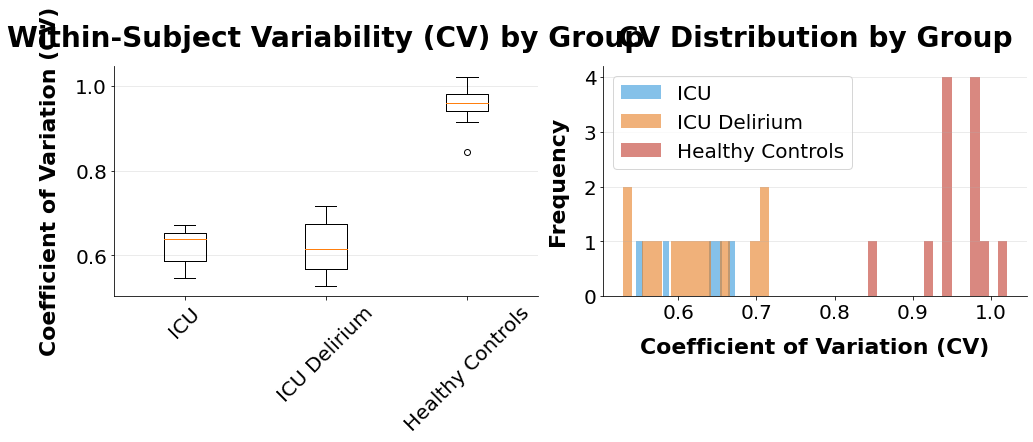

In [11]:
# Compare group heterogeneity using CV
if subject_stats_df is not None:
    try:
        from scipy.stats import kruskal
        
        # Test if CV differs between groups
        groups_cv = [subject_stats_df[subject_stats_df['group'] == g]['cv'].dropna().values 
                     for g in subject_stats_df['group'].unique()]
        group_names = subject_stats_df['group'].unique()
        
        # Kruskal-Wallis test on CV
        stat, pval = kruskal(*groups_cv)
        
        print("\nGroup Heterogeneity Comparison (Coefficient of Variation):")
        print("=" * 80)
        print(f"Kruskal-Wallis test: statistic = {stat:.3f}, p-value = {pval:.4e}")
        
        if pval < 0.05:
            print("→ Groups show significantly different heterogeneity")
        else:
            print("→ No significant difference in heterogeneity between groups")
        
        # Visualize CV distributions
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Boxplot of CV by group
        cv_data = [subject_stats_df[subject_stats_df['group'] == g]['cv'].dropna().values 
                   for g in group_names]
        axes[0].boxplot(cv_data, labels=group_names)
        axes[0].set_ylabel('Coefficient of Variation (CV)', fontweight='bold')
        axes[0].set_title('Within-Subject Variability (CV) by Group', fontweight='bold', pad=20)
        axes[0].grid(axis='y', alpha=0.3)
        axes[0].tick_params(axis='x', rotation=45)
        
        # Histogram of CV distributions
        for i, (group, cv_vals) in enumerate(zip(group_names, cv_data)):
            axes[1].hist(cv_vals, alpha=0.6, label=group, color=colors[i], bins=15)
        axes[1].set_xlabel('Coefficient of Variation (CV)', fontweight='bold')
        axes[1].set_ylabel('Frequency', fontweight='bold')
        axes[1].set_title('CV Distribution by Group', fontweight='bold', pad=20)
        axes[1].legend()
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in heterogeneity comparison: {e}")
        import traceback
        traceback.print_exc()

In [12]:
# Create individual SDI fingerprints (top/bottom regions per subject)
if unified_sdi_df is not None:
    try:
        from utils.connectome_utils import get_region_category_indices
        atlas_to_yeo7_df = pd.read_csv(ATLAS_TO_YEO7_CSV)
        
        # Add region category to unified_df if not present
        if 'region_category' not in unified_sdi_df.columns:
            unified_sdi_df['region_category'] = unified_sdi_df['parcel_id'].apply(
                lambda pid: get_region_category_indices(pid, atlas_to_yeo7_df)
            )
        
        # Compute mean SDI per region per subject
        fingerprints = []
        for subject_id in unified_sdi_df['subject_id'].unique():
            subj_data = unified_sdi_df[unified_sdi_df['subject_id'] == subject_id]
            region_means = subj_data.groupby('region_category')['sdi_value'].mean()
            
            # Get top 3 and bottom 3 regions
            top_regions = region_means.nlargest(3).index.tolist()
            bottom_regions = region_means.nsmallest(3).index.tolist()
            
            group = subj_data['group'].iloc[0]
            
            fingerprints.append({
                'subject_id': subject_id,
                'group': group,
                'top_regions': ', '.join(top_regions),
                'bottom_regions': ', '.join(bottom_regions),
                'global_mean_sdi': region_means.mean()
            })
        
        fingerprints_df = pd.DataFrame(fingerprints)
        
        print("\nIndividual SDI Fingerprints (Top 3 and Bottom 3 Regions):")
        print("=" * 80)
        display(fingerprints_df.head(10))
        
        # Analyze patterns: which regions appear most often in top/bottom?
        all_top_regions = []
        all_bottom_regions = []
        for _, row in fingerprints_df.iterrows():
            all_top_regions.extend(row['top_regions'].split(', '))
            all_bottom_regions.extend(row['bottom_regions'].split(', '))
        
        from collections import Counter
        top_counter = Counter(all_top_regions)
        bottom_counter = Counter(all_bottom_regions)
        
        print("\nMost Common Regions in Top 3 (High SDI):")
        for region, count in top_counter.most_common(5):
            print(f"  {region}: {count} subjects")
        
        print("\nMost Common Regions in Bottom 3 (Low SDI):")
        for region, count in bottom_counter.most_common(5):
            print(f"  {region}: {count} subjects")
        
    except Exception as e:
        print(f"Error creating fingerprints: {e}")
        import traceback
        traceback.print_exc()
        fingerprints_df = None


Individual SDI Fingerprints (Top 3 and Bottom 3 Regions):


,subject_id,group,top_regions,bottom_regions,global_mean_sdi
0,sub-01,ICU,"Thalamus, Brainstem, Amygdala","Other, Frontoparietal, Visual",1.237187
1,sub-02,ICU,"Thalamus, Default Mode, Amygdala","Other, Visual, Dorsal Attention",1.229487
2,sub-04,ICU,"Cerebellum, Thalamus, Brainstem","Frontoparietal, Other, Dorsal Attention",1.204438
3,sub-07,ICU,"Thalamus, Cerebellum, Default Mode","Visual, Dorsal Attention, Other",1.229684
4,sub-08,ICU,"Thalamus, Cerebellum, Brainstem","Visual, Dorsal Attention, Other",1.241978
5,sub-09,ICU Delirium,"Thalamus, Brainstem, Cerebellum","Other, Frontoparietal, Dorsal Attention",1.429505
6,sub-10,ICU Delirium,"Thalamus, Cerebellum, Brainstem","Other, Frontoparietal, Visual",1.295439
7,sub-11,ICU Delirium,"Thalamus, Amygdala, Cerebellum","Other, Brainstem, Visual",0.974466
8,sub-12,ICU Delirium,"Cerebellum, Brainstem, Thalamus","Other, Visual, Dorsal Attention",1.253821
9,sub-13,ICU Delirium,"Thalamus, Brainstem, Cerebellum","Other, Dorsal Attention, Visual",1.129012



Most Common Regions in Top 3 (High SDI):
  Thalamus: 29 subjects
  Default Mode: 13 subjects
  Basal Ganglia: 13 subjects
  Brainstem: 12 subjects
  Cerebellum: 11 subjects

Most Common Regions in Bottom 3 (Low SDI):
  Visual: 23 subjects
  Other: 21 subjects
  Frontoparietal: 14 subjects
  Dorsal Attention: 13 subjects
  Cerebellum: 10 subjects


### 10.3 Network-Level Coherence Analysis

This analysis examines **within-network coherence**: how similar are SDI values between parcels within the same network? High coherence suggests the network acts as a unit; low coherence suggests heterogeneous changes.

Network Coherence (Within-Network Correlation):


group,Healthy Controls,ICU,ICU Delirium
region,,,
Amygdala,-0.315,-0.300,-0.028
Basal Ganglia,0.340,-0.044,0.260
Brainstem,0.749,0.200,0.521
Cerebellum,0.385,0.500,0.517
Default Mode,0.125,0.186,0.288
Dorsal Attention,0.164,0.172,0.414
Frontoparietal,0.120,0.120,0.282
Limbic,0.247,0.172,0.320
Other,0.790,0.300,0.860


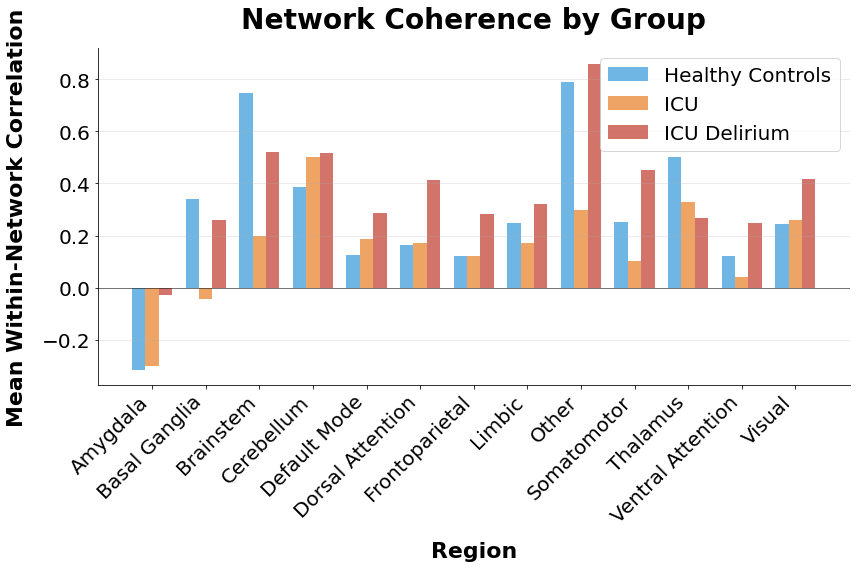


STATISTICAL SIGNIFICANCE TESTING
Note: Testing individual pairwise correlations (not mean coherence)

Total pairwise correlations collected: 32877
Regions: 13
Groups: ['ICU' 'ICU Delirium' 'Healthy Controls']

Primary Test: Kruskal-Wallis (comparing all 3 groups)
Testing individual pairwise correlations within each region
--------------------------------------------------------------------------------


,region,n_correlations,kw_statistic,kw_pvalue,kw_pvalue_corrected,significant
0,Somatomotor,"ICU: 1378, ICU Delirium: 1378, Healthy Control...",529.4923,0.0000,0.0000,True
1,Default Mode,"ICU: 3160, ICU Delirium: 3160, Healthy Control...",331.5175,0.0000,0.0000,True
2,Visual,"ICU: 2145, ICU Delirium: 2145, Healthy Control...",263.1615,0.0000,0.0000,True
3,Dorsal Attention,"ICU: 903, ICU Delirium: 903, Healthy Controls:...",213.2831,0.0000,0.0000,True
4,Thalamus,"ICU: 861, ICU Delirium: 861, Healthy Controls:...",185.0821,0.0000,0.0000,True
5,Ventral Attention,"ICU: 1035, ICU Delirium: 1035, Healthy Control...",120.4655,0.0000,0.0000,True
6,Frontoparietal,"ICU: 990, ICU Delirium: 990, Healthy Controls:...",106.1010,0.0000,0.0000,True
7,Basal Ganglia,"ICU: 153, ICU Delirium: 153, Healthy Controls:...",49.5882,0.0000,0.0000,True
8,Limbic,"ICU: 325, ICU Delirium: 325, Healthy Controls:...",12.5967,0.0018,0.0027,True
9,Brainstem,"ICU: 6, ICU Delirium: 6, Healthy Controls: 6",6.9998,0.0302,0.0393,True



Significant regions (FDR corrected, α = 0.05): 10
Regions with significant group differences:
  *** Somatomotor: p = 0.0000
  *** Default Mode: p = 0.0000
  *** Visual: p = 0.0000
  *** Dorsal Attention: p = 0.0000
  *** Thalamus: p = 0.0000
  *** Ventral Attention: p = 0.0000
  *** Frontoparietal: p = 0.0000
  *** Basal Ganglia: p = 0.0000
  ** Limbic: p = 0.0027
  * Brainstem: p = 0.0393

POST-HOC PAIRWISE COMPARISONS: Mann-Whitney U Test

Results (FDR corrected):
--------------------------------------------------------------------------------


,region,group1,group2,n1,n2,mean1,mean2,mean_diff,pvalue,pvalue_corrected,significant
27,Amygdala,ICU,ICU Delirium,1,1,-0.3000,-0.0280,-0.2720,1.0000,1.0000,False
28,Amygdala,ICU,Healthy Controls,1,1,-0.3000,-0.3147,0.0147,1.0000,1.0000,False
29,Amygdala,ICU Delirium,Healthy Controls,1,1,-0.0280,-0.3147,0.2867,1.0000,1.0000,False
25,Basal Ganglia,ICU,Healthy Controls,153,153,-0.0444,0.3405,-0.3849,0.0000,0.0000,True
24,Basal Ganglia,ICU,ICU Delirium,153,153,-0.0444,0.2602,-0.3046,0.0000,0.0000,True
26,Basal Ganglia,ICU Delirium,Healthy Controls,153,153,0.2602,0.3405,-0.0803,0.0120,0.0187,True
34,Brainstem,ICU,Healthy Controls,6,6,0.2000,0.7494,-0.5494,0.0050,0.0081,True
33,Brainstem,ICU,ICU Delirium,6,6,0.2000,0.5210,-0.3210,0.2290,0.3189,False
35,Brainstem,ICU Delirium,Healthy Controls,6,6,0.5210,0.7494,-0.2284,0.5211,0.6774,False
36,Cerebellum,ICU,ICU Delirium,1,1,0.5000,0.5175,-0.0175,1.0000,1.0000,False



Significant pairwise comparisons: 26
--------------------------------------------------------------------------------
  Basal Ganglia: ICU has lower coherence than Healthy Controls (p = 0.0000, diff = -0.385)
  Basal Ganglia: ICU has lower coherence than ICU Delirium (p = 0.0000, diff = -0.305)
  Basal Ganglia: ICU Delirium has lower coherence than Healthy Controls (p = 0.0187, diff = -0.080)
  Brainstem: ICU has lower coherence than Healthy Controls (p = 0.0081, diff = -0.549)
  Default Mode: ICU Delirium has higher coherence than Healthy Controls (p = 0.0000, diff = 0.163)
  Default Mode: ICU has higher coherence than Healthy Controls (p = 0.0000, diff = 0.061)
  Default Mode: ICU has lower coherence than ICU Delirium (p = 0.0000, diff = -0.102)
  Dorsal Attention: ICU Delirium has higher coherence than Healthy Controls (p = 0.0000, diff = 0.249)
  Dorsal Attention: ICU has lower coherence than ICU Delirium (p = 0.0000, diff = -0.242)
  Dorsal Attention: ICU has higher coherence tha

In [13]:
# Network coherence analysis
if unified_sdi_df is not None and 'region_category' in unified_sdi_df.columns:
    try:
        from scipy.stats import spearmanr
        
        coherence_results = []
        # Store all pairwise correlations for statistical testing
        all_pairwise_corrs = []
        
        for region in unified_sdi_df['region_category'].dropna().unique():
            region_data = unified_sdi_df[unified_sdi_df['region_category'] == region]
            
            # Get parcels in this region
            parcels_in_region = region_data['parcel_id'].unique()
            
            if len(parcels_in_region) < 2:
                continue
            
            # For each group, compute within-network correlation
            for group in unified_sdi_df['group'].unique():
                group_region_data = region_data[region_data['group'] == group]
                
                # Pivot: subjects × parcels
                pivot_data = group_region_data.pivot_table(
                    index='subject_id',
                    columns='parcel_id',
                    values='sdi_value'
                )
                
                if pivot_data.shape[0] < 2 or pivot_data.shape[1] < 2:
                    continue
                
                # Compute ALL pairwise correlations between parcels (not just mean)
                parcel_corrs = []
                parcel_cols = pivot_data.columns.values
                for i, p1 in enumerate(parcel_cols):
                    for p2 in parcel_cols[i+1:]:
                        vec1 = pivot_data[p1].values
                        vec2 = pivot_data[p2].values
                        # Remove NaN pairs
                        mask = np.isfinite(vec1) & np.isfinite(vec2)
                        if np.sum(mask) > 2:
                            corr, _ = spearmanr(vec1[mask], vec2[mask])
                            if np.isfinite(corr):
                                parcel_corrs.append(corr)
                                # Store individual correlation for statistical testing
                                all_pairwise_corrs.append({
                                    'region': region,
                                    'group': group,
                                    'parcel_pair': f"{p1}_{p2}",
                                    'correlation': corr
                                })
                
                if len(parcel_corrs) > 0:
                    mean_coherence = np.mean(parcel_corrs)
                    coherence_results.append({
                        'region': region,
                        'group': group,
                        'mean_coherence': mean_coherence,
                        'n_parcels': len(parcels_in_region),
                        'n_subjects': pivot_data.shape[0],
                        'n_pairwise_corrs': len(parcel_corrs)
                    })
        
        coherence_df = pd.DataFrame(coherence_results)
        
        if len(coherence_df) > 0:
            print("Network Coherence (Within-Network Correlation):")
            print("=" * 80)
            
            # Pivot for visualization
            coherence_pivot = coherence_df.pivot_table(
                index='region',
                columns='group',
                values='mean_coherence'
            ).round(3)
            
            display(coherence_pivot)
            
            # Visualize
            fig, ax = plt.subplots(figsize=(12, 8))
            
            regions = coherence_pivot.index
            x = np.arange(len(regions))
            width = 0.25
            
            for i, group in enumerate(coherence_pivot.columns):
                offset = (i - 1) * width
                values = coherence_pivot[group].values
                ax.bar(x + offset, values, width, label=group, color=colors[i], alpha=0.7)
            
            ax.set_xlabel('Region', fontweight='bold')
            ax.set_ylabel('Mean Within-Network Correlation', fontweight='bold')
            ax.set_title('Network Coherence by Group', fontweight='bold', pad=20)
            ax.set_xticks(x)
            ax.set_xticklabels(regions, rotation=45, ha='right')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            
            plt.tight_layout()
            plt.show()
            
            # Statistical significance testing using individual pairwise correlations
            print("\n" + "=" * 80)
            print("STATISTICAL SIGNIFICANCE TESTING")
            print("=" * 80)
            print("Note: Testing individual pairwise correlations (not mean coherence)")
            print("=" * 80)
            
            from scipy.stats import kruskal, mannwhitneyu
            from statsmodels.stats.multitest import multipletests
            
            # Convert all_pairwise_corrs to DataFrame for easier manipulation
            pairwise_df = pd.DataFrame(all_pairwise_corrs)
            
            if len(pairwise_df) > 0:
                print(f"\nTotal pairwise correlations collected: {len(pairwise_df)}")
                print(f"Regions: {pairwise_df['region'].nunique()}")
                print(f"Groups: {pairwise_df['group'].unique()}")
                
                # Test each region for group differences using individual correlations
                statistical_results = []
                
                for region in pairwise_df['region'].unique():
                    region_data = pairwise_df[pairwise_df['region'] == region]
                    
                    # Get correlation values for each group
                    groups_data = {}
                    for group in pairwise_df['group'].unique():
                        group_data = region_data[region_data['group'] == group]['correlation'].values
                        if len(group_data) > 0:
                            groups_data[group] = group_data
                    
                    if len(groups_data) < 2:
                        continue
                    
                    # Kruskal-Wallis test (non-parametric, appropriate for small samples)
                    groups_list = list(groups_data.values())
                    if all(len(g) > 0 for g in groups_list):
                        try:
                            kw_stat, kw_pval = kruskal(*groups_list)
                            
                            # Post-hoc pairwise comparisons
                            group_names = list(groups_data.keys())
                            posthoc_results = []
                            
                            for i, g1 in enumerate(group_names):
                                for g2 in group_names[i+1:]:
                                    data1 = groups_data[g1]
                                    data2 = groups_data[g2]
                                    
                                    if len(data1) > 0 and len(data2) > 0:
                                        # Mann-Whitney U test
                                        u_stat, u_pval = mannwhitneyu(data1, data2, alternative='two-sided')
                                        
                                        # Compute mean difference
                                        mean_diff = np.mean(data1) - np.mean(data2)
                                        
                                        posthoc_results.append({
                                            'region': region,
                                            'group1': g1,
                                            'group2': g2,
                                            'pvalue': u_pval,
                                            'mean_diff': mean_diff,
                                            'mean1': np.mean(data1),
                                            'mean2': np.mean(data2),
                                            'n1': len(data1),
                                            'n2': len(data2)
                                        })
                            
                            statistical_results.append({
                                'region': region,
                                'kw_statistic': kw_stat,
                                'kw_pvalue': kw_pval,
                                'n_groups': len(groups_data),
                                'n_correlations': {g: len(groups_data[g]) for g in group_names},
                                'posthoc_tests': posthoc_results
                            })
                        except Exception as e:
                            print(f"Warning: Could not test {region}: {e}")
                            continue
            else:
                print("No pairwise correlations collected for statistical testing")
                statistical_results = []
            
            # Create summary table
            if len(statistical_results) > 0:
                # Primary test results (Kruskal-Wallis)
                primary_results = []
                for result in statistical_results:
                    primary_results.append({
                        'region': result['region'],
                        'kw_statistic': result['kw_statistic'],
                        'kw_pvalue': result['kw_pvalue'],
                        'n_groups': result['n_groups']
                    })
                
                primary_df = pd.DataFrame(primary_results)
                
                # Apply FDR correction to primary tests
                primary_df['kw_pvalue_corrected'] = multipletests(
                    primary_df['kw_pvalue'], method='fdr_bh', alpha=0.05
                )[1]
                primary_df['significant'] = primary_df['kw_pvalue_corrected'] < 0.05
                
                # Sort by p-value
                primary_df = primary_df.sort_values('kw_pvalue')
                
                print("\nPrimary Test: Kruskal-Wallis (comparing all 3 groups)")
                print("Testing individual pairwise correlations within each region")
                print("-" * 80)
                
                # Add sample size information
                display_cols = ['region', 'kw_statistic', 'kw_pvalue', 
                              'kw_pvalue_corrected', 'significant']
                display_df = primary_df[display_cols].copy()
                
                # Add sample sizes from statistical_results
                n_corr_info = []
                for result in statistical_results:
                    region = result['region']
                    n_corr_str = ', '.join([f"{g}: {n}" for g, n in result['n_correlations'].items()])
                    n_corr_info.append({'region': region, 'n_correlations': n_corr_str})
                
                if n_corr_info:
                    n_corr_df = pd.DataFrame(n_corr_info)
                    display_df = display_df.merge(n_corr_df, on='region', how='left')
                    display_cols = ['region', 'n_correlations', 'kw_statistic', 'kw_pvalue', 
                                  'kw_pvalue_corrected', 'significant']
                    display_df = display_df[display_cols]
                
                display(display_df.round(4))
                
                # Count significant regions
                sig_regions = primary_df[primary_df['significant'] == True]
                print(f"\nSignificant regions (FDR corrected, α = 0.05): {len(sig_regions)}")
                if len(sig_regions) > 0:
                    print("Regions with significant group differences:")
                    for _, row in sig_regions.iterrows():
                        sig_level = "***" if row['kw_pvalue_corrected'] < 0.001 else \
                                   "**" if row['kw_pvalue_corrected'] < 0.01 else "*"
                        print(f"  {sig_level} {row['region']}: p = {row['kw_pvalue_corrected']:.4f}")
                
                # Post-hoc pairwise comparisons
                all_posthoc = []
                for result in statistical_results:
                    all_posthoc.extend(result['posthoc_tests'])
                
                if len(all_posthoc) > 0:
                    posthoc_df = pd.DataFrame(all_posthoc)
                    
                    # Apply FDR correction across all post-hoc tests
                    posthoc_df['pvalue_corrected'] = multipletests(
                        posthoc_df['pvalue'], method='fdr_bh', alpha=0.05
                    )[1]
                    posthoc_df['significant'] = posthoc_df['pvalue_corrected'] < 0.05
                    
                    # Sort by region and p-value
                    posthoc_df = posthoc_df.sort_values(['region', 'pvalue_corrected'])
                    
                    print("\n" + "=" * 80)
                    print("POST-HOC PAIRWISE COMPARISONS: Mann-Whitney U Test")
                    print("=" * 80)
                    print("\nResults (FDR corrected):")
                    print("-" * 80)
                    display_cols = ['region', 'group1', 'group2', 'n1', 'n2', 'mean1', 'mean2', 
                                   'mean_diff', 'pvalue', 'pvalue_corrected', 'significant']
                    # Ensure all columns exist
                    available_cols = [col for col in display_cols if col in posthoc_df.columns]
                    display(posthoc_df[available_cols].round(4))
                    
                    # Summary of significant comparisons
                    sig_posthoc = posthoc_df[posthoc_df['significant'] == True]
                    if len(sig_posthoc) > 0:
                        print(f"\nSignificant pairwise comparisons: {len(sig_posthoc)}")
                        print("-" * 80)
                        for _, row in sig_posthoc.iterrows():
                            direction = "higher" if row['mean_diff'] > 0 else "lower"
                            print(f"  {row['region']}: {row['group1']} has {direction} coherence than {row['group2']} "
                                  f"(p = {row['pvalue_corrected']:.4f}, diff = {row['mean_diff']:.3f})")
                    else:
                        print("\nNo significant pairwise comparisons after FDR correction")
                
                
            
            print("\nInterpretation:")
            print("- High coherence (>0.5): Network parcels change together")
            print("- Low coherence (<0.2): Network parcels change independently")
            print("- Statistical tests identify regions where groups differ significantly in coherence")
        else:
            print("Could not compute network coherence (insufficient data)")
            coherence_df = None
            
    except Exception as e:
        print(f"Error in network coherence analysis: {e}")
        import traceback
        traceback.print_exc()
        coherence_df = None
else:
    print("Skipping: SDI data or region categories not available")
    coherence_df = None

Permutation Test for Overall Group Differences:
Number of permutations: 10,000


Observed Kruskal-Wallis statistic: 36.5726
Permutation p-value: 0.000000
Asymptotic p-value (from earlier): 0.000000


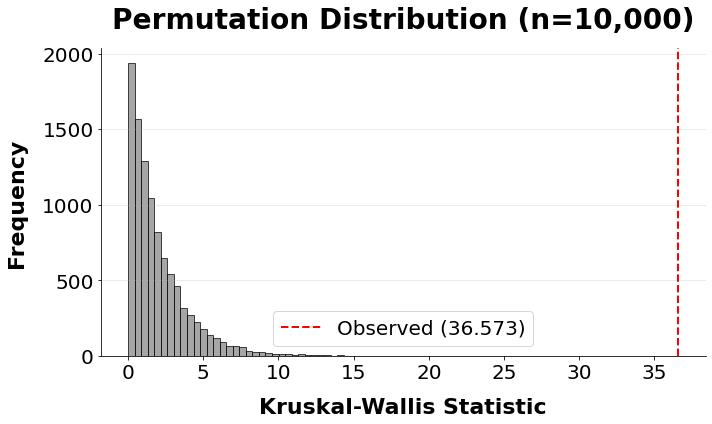

In [26]:
# Permutation testing for group differences
if unified_sdi_df is not None:
    try:
        n_permutations = 10000
        
        def permutation_test_groups(data_dict, n_perm=10000):
            """Permutation test for group differences using Kruskal-Wallis statistic"""
            from scipy.stats import kruskal
            
            # Observed statistic
            groups_data = list(data_dict.values())
            observed_stat, _ = kruskal(*groups_data)
            
            # Permutation distribution
            all_data = np.concatenate(groups_data)
            n_per_group = [len(g) for g in groups_data]
            
            permuted_stats = []
            for _ in range(n_perm):
                # Shuffle all data
                shuffled = np.random.permutation(all_data)
                
                # Split according to original group sizes
                split_data = []
                start_idx = 0
                for n in n_per_group:
                    split_data.append(shuffled[start_idx:start_idx+n])
                    start_idx += n
                
                # Compute statistic
                stat, _ = kruskal(*split_data)
                permuted_stats.append(stat)
            
            # P-value: proportion of permuted stats >= observed
            p_value = np.mean(np.array(permuted_stats) >= observed_stat)
            
            return observed_stat, p_value, permuted_stats
        
        # Test overall group differences
        groups_data_dict = {}
        for group in unified_sdi_df['group'].unique():
            group_data = unified_sdi_df[unified_sdi_df['group'] == group]['sdi_value'].values
            group_data_clean = group_data[np.isfinite(group_data)]
            groups_data_dict[group] = group_data_clean
        
        print("Permutation Test for Overall Group Differences:")
        print("=" * 80)
        print(f"Number of permutations: {n_permutations:,}")
        
        obs_stat, perm_pval, perm_dist = permutation_test_groups(groups_data_dict, n_perm=n_permutations)
        
        print(f"Observed Kruskal-Wallis statistic: {obs_stat:.4f}")
        print(f"Permutation p-value: {perm_pval:.6f}")
        print(f"Asymptotic p-value (from earlier): {primary_test['pvalue'].values[0]:.6f}")
        
        # Visualize permutation distribution
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(perm_dist, bins=50, alpha=0.7, color='gray', edgecolor='black')
        ax.axvline(obs_stat, color='red', linestyle='--', linewidth=2, label=f'Observed ({obs_stat:.3f})')
        ax.set_xlabel('Kruskal-Wallis Statistic', fontweight='bold')
        ax.set_ylabel('Frequency', fontweight='bold')
        ax.set_title(f'Permutation Distribution (n={n_permutations:,})', fontweight='bold', pad=20)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in permutation testing: {e}")
        import traceback
        traceback.print_exc()

In [20]:
# Permutation testing for regional differences
if unified_sdi_df is not None and 'region_category' in unified_sdi_df.columns:
    try:
        # Test a few key regions (to save computation time)
        key_regions = ['Thalamus', 'Basal Ganglia', 'Default Mode', 'Visual']
        
        perm_regional_results = []
        
        for region in key_regions:
            region_data = unified_sdi_df[unified_sdi_df['region_category'] == region]
            
            if len(region_data) == 0:
                continue
            
            # Get data per group
            groups_data_dict = {}
            for group in unified_sdi_df['group'].unique():
                group_region_data = region_data[region_data['group'] == group]['sdi_value'].values
                group_region_data_clean = group_region_data[np.isfinite(group_region_data)]
                if len(group_region_data_clean) > 0:
                    groups_data_dict[group] = group_region_data_clean
            
            if len(groups_data_dict) < 2:
                continue
            
            # Permutation test
            obs_stat, perm_pval, _ = permutation_test_groups(groups_data_dict, n_perm=5000)
            
            # Get asymptotic p-value from earlier results
            asymp_pval = None
            if 'regional_tests' in locals():
                region_row = regional_tests[regional_tests['region_category'] == region]
                if len(region_row) > 0:
                    asymp_pval = region_row['pvalue'].iloc[0]
            
            perm_regional_results.append({
                'region': region,
                'observed_statistic': obs_stat,
                'permutation_pvalue': perm_pval,
                'asymptotic_pvalue': asymp_pval
            })
        
        perm_regional_df = pd.DataFrame(perm_regional_results)
        
        if len(perm_regional_df) > 0:
            print("\nPermutation Tests for Regional Differences:")
            print("=" * 80)
            display(perm_regional_df.round(6))
            
            print("\nComparison: Permutation vs Asymptotic p-values")
            print("Permutation tests are more robust with small samples")
        else:
            print("Could not compute regional permutation tests")
            
    except Exception as e:
        print(f"Error in regional permutation testing: {e}")
        import traceback
        traceback.print_exc()


Permutation Tests for Regional Differences:


,region,observed_statistic,permutation_pvalue,asymptotic_pvalue
0,Thalamus,229.011013,0.0000,0.000000
1,Basal Ganglia,146.493603,0.0000,0.000000
2,Default Mode,15.026891,0.0006,0.000546
3,Visual,42.545584,0.0000,0.000000



Comparison: Permutation vs Asymptotic p-values
Permutation tests are more robust with small samples


### 10.5 Cross-Network Correlation Analysis

This analysis examines relationships **between** networks: do changes in one network correlate with changes in another? Altered network relationships may indicate disrupted network interactions in delirium.

Cross-Network Correlation Matrix (All Subjects):


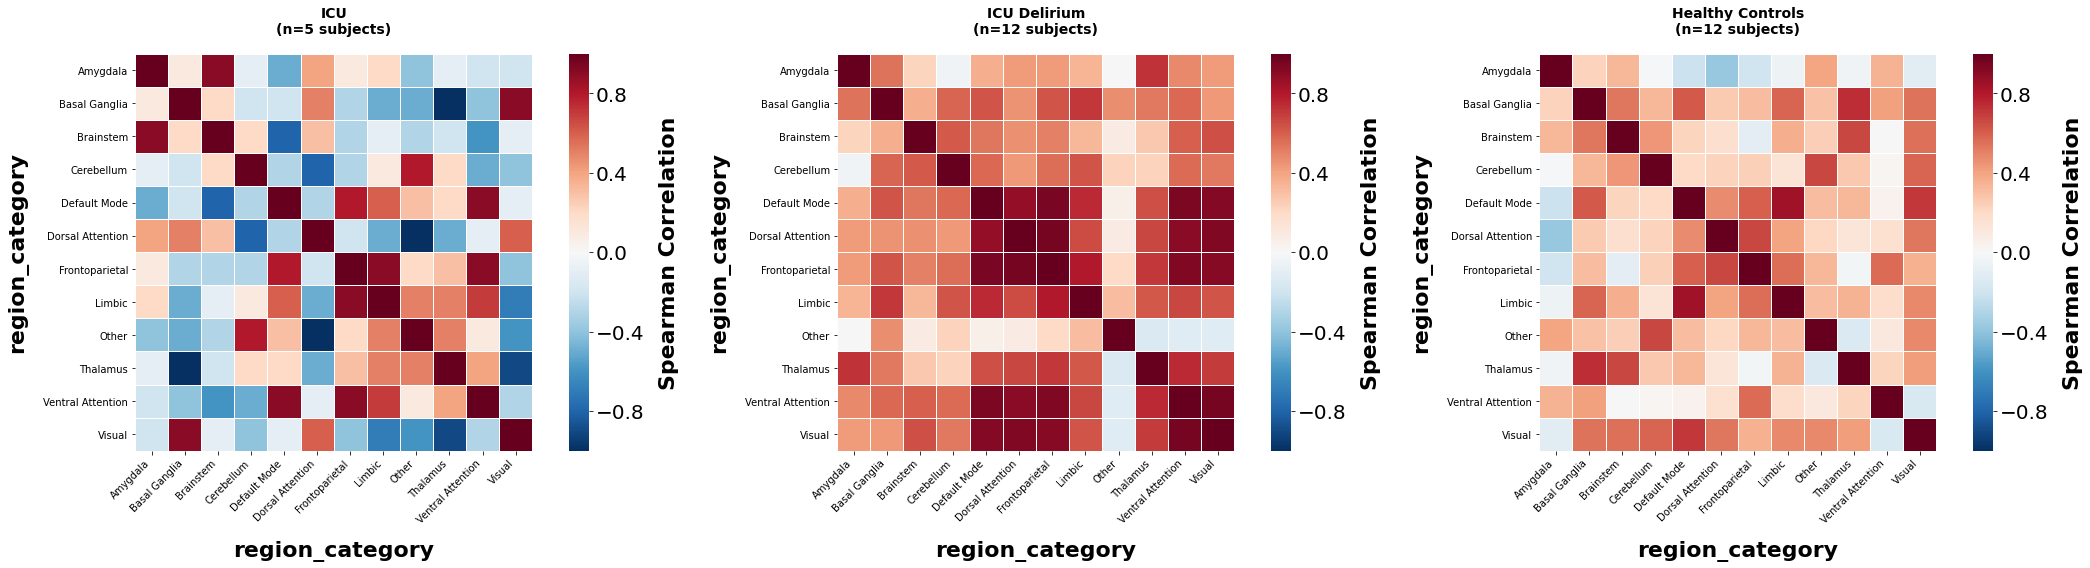


STATISTICAL TESTING: ICU Delirium vs Healthy Controls
Testing network pairs where ICU Delirium differs from HC
Then checking if ICU differs from ICU Delirium on same pairs

No network pairs found where ICU Delirium differs from HC and ICU


In [17]:
# Cross-network correlation analysis
if unified_sdi_df is not None and 'region_category' in unified_sdi_df.columns:
    try:
        from scipy.stats import spearmanr
        
        # Compute mean SDI per network per subject
        network_means = unified_sdi_df.groupby(['subject_id', 'region_category'])['sdi_value'].mean().unstack()
        
        # Remove any networks with all NaN
        network_means = network_means.dropna(axis=1, how='all')
        
        # Compute correlation matrix between networks
        network_corr = network_means.corr(method='spearman')
        
        print("Cross-Network Correlation Matrix (All Subjects):")
        print("=" * 80)
        
        # Compare correlations between groups
        group_corrs = {}
        group_sizes = {}  # Store group sizes for later use
        for group in unified_sdi_df['group'].unique():
            group_subjects = unified_sdi_df[unified_sdi_df['group'] == group]['subject_id'].unique()
            group_sizes[group] = len(group_subjects)
            group_network_means = network_means.loc[network_means.index.isin(group_subjects)]
            if group_network_means.shape[0] > 1:
                group_corr = group_network_means.corr(method='spearman')
                group_corrs[group] = group_corr
        
        # Visualize correlation matrices by group
        n_groups = len(group_corrs)
        if n_groups > 0:
            # Make heatmaps larger and remove annotations
            fig, axes = plt.subplots(1, n_groups, figsize=(10*n_groups, 8))
            if n_groups == 1:
                axes = [axes]
            
            for idx, (group, group_corr) in enumerate(group_corrs.items()):
                sns.heatmap(group_corr, annot=False, fmt='.2f', cmap='RdBu_r', center=0,
                           ax=axes[idx], cbar_kws={'label': 'Spearman Correlation'},
                           vmin=-1, vmax=1, square=True, linewidths=0.5)
                axes[idx].set_title(f'{group}\n(n={group_sizes.get(group, 0)} subjects)', 
                                   fontweight='bold', pad=20, fontsize=14)
                # Rotate labels and make them smaller to avoid overlap
                axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right', fontsize=10)
                axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=0, fontsize=10)
            
            plt.tight_layout()
            plt.show()
        
        # Statistical testing: Focus on ICU Delirium vs HC differences
        print("\n" + "=" * 80)
        print("STATISTICAL TESTING: ICU Delirium vs Healthy Controls")
        print("=" * 80)
        print("Testing network pairs where ICU Delirium differs from HC")
        print("Then checking if ICU differs from ICU Delirium on same pairs")
        print("=" * 80)
        
        from scipy.stats import norm
        from statsmodels.stats.multitest import multipletests
        
        def fisher_z_transform(r):
            """Fisher's z-transformation for correlation coefficient"""
            return 0.5 * np.log((1 + r) / (1 - r))
        
        def compare_correlations(r1, r2, n1, n2):
            """
            Compare two correlation coefficients using Fisher's z-test
            
            Parameters:
            -----------
            r1, r2 : float
                Correlation coefficients
            n1, n2 : int
                Sample sizes (number of subjects)
            
            Returns:
            --------
            z_stat : float
                Z-statistic
            p_value : float
                Two-tailed p-value
            """
            # Transform to z-scores
            z1 = fisher_z_transform(r1)
            z2 = fisher_z_transform(r2)
            
            # Standard error of difference
            se_diff = np.sqrt(1/(n1-3) + 1/(n2-3))
            
            # Z-statistic
            z_stat = (z1 - z2) / se_diff
            
            # Two-tailed p-value
            p_value = 2 * (1 - norm.cdf(abs(z_stat)))
            
            return z_stat, p_value
        
        # Get all network pairs (upper triangle, excluding diagonal)
        all_network_pairs = []
        if len(group_corrs) > 0:
            # Use first group's correlation matrix to get network names
            first_group = list(group_corrs.keys())[0]
            networks = group_corrs[first_group].columns.tolist()
            
            for i, net1 in enumerate(networks):
                for net2 in networks[i+1:]:
                    all_network_pairs.append((net1, net2))
        
        # Get sample sizes per group
        group_sizes = {}
        for group in unified_sdi_df['group'].unique():
            group_subjects = unified_sdi_df[unified_sdi_df['group'] == group]['subject_id'].unique()
            group_sizes[group] = len(group_subjects)
        
        # Test all network pairs
        comparison_results = []
        
        for net1, net2 in all_network_pairs:
            # Get correlations for each group
            group_corr_values = {}
            for group, group_corr in group_corrs.items():
                if net1 in group_corr.columns and net2 in group_corr.columns:
                    corr_val = group_corr.loc[net1, net2]
                    if np.isfinite(corr_val):
                        group_corr_values[group] = {
                            'correlation': corr_val,
                            'n': group_sizes.get(group, 0)
                        }
            
            # Perform pairwise comparisons between groups
            groups_list = list(group_corr_values.keys())
            for i, g1 in enumerate(groups_list):
                for g2 in groups_list[i+1:]:
                    r1 = group_corr_values[g1]['correlation']
                    r2 = group_corr_values[g2]['correlation']
                    n1 = group_corr_values[g1]['n']
                    n2 = group_corr_values[g2]['n']
                    
                    if n1 > 3 and n2 > 3:  # Need at least 4 subjects for Fisher's z
                        z_stat, p_val = compare_correlations(r1, r2, n1, n2)
                        
                        comparison_results.append({
                            'network_pair': f"{net1} - {net2}",
                            'group1': g1,
                            'group2': g2,
                            'corr1': r1,
                            'corr2': r2,
                            'n1': n1,
                            'n2': n2,
                            'z_statistic': z_stat,
                            'pvalue': p_val,
                            'corr_diff': r1 - r2
                        })
        
        if len(comparison_results) > 0:
            comparison_df = pd.DataFrame(comparison_results)
            
            # Apply FDR correction
            comparison_df['pvalue_corrected'] = multipletests(
                comparison_df['pvalue'], method='fdr_bh', alpha=0.05
            )[1]
            comparison_df['significant'] = comparison_df['pvalue_corrected'] < 0.05
            
            # Find network pairs where ICU Delirium vs HC is significant
            hc_vs_del = comparison_df[
                ((comparison_df['group1'] == 'Healthy Controls') & (comparison_df['group2'] == 'ICU Delirium')) |
                ((comparison_df['group1'] == 'ICU Delirium') & (comparison_df['group2'] == 'Healthy Controls'))
            ]
            sig_hc_vs_del = hc_vs_del[hc_vs_del['significant'] == True]
            
            if len(sig_hc_vs_del) > 0:
                # For each significant HC vs Del pair, check ICU vs Del
                results = []
                for _, row in sig_hc_vs_del.iterrows():
                    pair = row['network_pair']
                    # Get ICU vs Del comparison for this pair
                    icu_vs_del = comparison_df[
                        (comparison_df['network_pair'] == pair) &
                        (((comparison_df['group1'] == 'ICU') & (comparison_df['group2'] == 'ICU Delirium')) |
                         ((comparison_df['group1'] == 'ICU Delirium') & (comparison_df['group2'] == 'ICU')))
                    ]
                    
                    if len(icu_vs_del) > 0:
                        icu_del_sig = icu_vs_del['significant'].iloc[0]
                        # Report only if ICU Delirium ≠ HC but ICU ≈ ICU Delirium (not significantly different)
                        if icu_del_sig:
                            # Get correlation values for all groups
                            net1, net2 = pair.split(' - ')
                            hc_corr = None
                            icu_corr = None
                            del_corr = None
                            
                            for group, group_corr in group_corrs.items():
                                if net1 in group_corr.columns and net2 in group_corr.columns:
                                    corr_val = group_corr.loc[net1, net2]
                                    if group == 'Healthy Controls':
                                        hc_corr = corr_val
                                    elif group == 'ICU':
                                        icu_corr = corr_val
                                    elif group == 'ICU Delirium':
                                        del_corr = corr_val
                            
                            results.append({
                                'Network Pair': pair,
                                'HC': hc_corr,
                                'ICU': icu_corr,
                                'ICU Delirium': del_corr,
                                'HC vs Del (p)': row['pvalue_corrected'],
                                'ICU vs Del (p)': icu_vs_del['pvalue_corrected'].iloc[0]
                            })
                
                if len(results) > 0:
                    results_df = pd.DataFrame(results)
                    print(f"\nNetwork pairs where ICU Delirium ≠ HC, but ICU ≈ ICU Delirium:")
                    print(f"(ICU Delirium differs from HC and ICU )")
                    print("-" * 80)
                    display(results_df.round(3))
                else:
                    print("\nNo network pairs found where ICU Delirium differs from HC and ICU")
            else:
                print("\nNo significant differences between ICU Delirium and Healthy Controls")
            

        
    except Exception as e:
        print(f"Error in cross-network correlation analysis: {e}")
        import traceback
        traceback.print_exc() 

NETWORK HUB ANALYSIS
Identifying network hubs (most connected networks) and comparing hub properties between groups


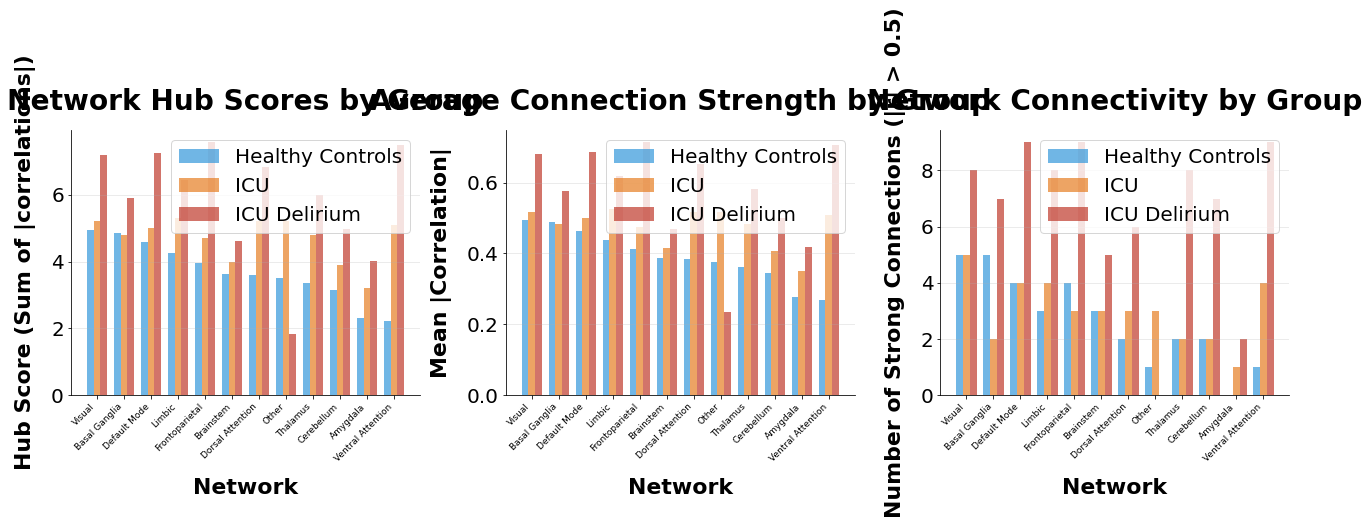


Top 5 Hub Networks (by Hub Score):
--------------------------------------------------------------------------------

Healthy Controls:
  Visual: 4.930
  Basal Ganglia: 4.853
  Default Mode: 4.573
  Limbic: 4.252
  Frontoparietal: 3.958

ICU:
  Limbic: 5.300
  Visual: 5.200
  Dorsal Attention: 5.200
  Other: 5.200
  Ventral Attention: 5.100

ICU Delirium:
  Frontoparietal: 7.566
  Ventral Attention: 7.483
  Default Mode: 7.238
  Visual: 7.182
  Dorsal Attention: 6.832

STATISTICAL TESTING: Hub Score Differences

No networks show significant hub score differences between groups

Interpretation:
- High hub score: Network is highly connected to other networks
- Low hub score: Network is relatively isolated
- Changes in hub properties may indicate altered network integration in delirium


In [21]:
# Network Hub Analysis
# Identifies which networks are most connected (hub networks) and whether hub properties differ in delirium
if unified_sdi_df is not None and 'region_category' in unified_sdi_df.columns:
    try:
        print("=" * 80)
        print("NETWORK HUB ANALYSIS")
        print("=" * 80)
        print("Identifying network hubs (most connected networks) and comparing hub properties between groups")
        print("=" * 80)
        
        # Use group_corrs from cross-network correlation analysis if available
        if 'group_corrs' in locals() and len(group_corrs) > 0:
            hub_results = []
            
            for group, group_corr in group_corrs.items():
                # Calculate hub score for each network
                # Hub score = sum of absolute correlations with all other networks
                hub_scores = group_corr.abs().sum(axis=1) - 1  # Subtract 1 for self-correlation (diagonal)
                
                # Calculate mean absolute correlation (average connection strength)
                mean_abs_corr = group_corr.abs().mean(axis=1)
                
                # Calculate number of strong connections (|r| > 0.5)
                strong_connections = (group_corr.abs() > 0.5).sum(axis=1) - 1  # Subtract 1 for self
                
                for network in hub_scores.index:
                    hub_results.append({
                        'Group': group,
                        'Network': network,
                        'Hub Score': hub_scores[network],
                        'Mean Abs Correlation': mean_abs_corr[network],
                        'N Strong Connections': strong_connections[network]
                    })
            
            hub_df = pd.DataFrame(hub_results)
            
            # Visualize hub scores by group
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # Plot 1: Hub scores
            hub_pivot = hub_df.pivot_table(index='Network', columns='Group', values='Hub Score')
            hub_pivot = hub_pivot.sort_values('Healthy Controls', ascending=False)
            
            x = np.arange(len(hub_pivot))
            width = 0.25
            for i, group in enumerate(['Healthy Controls', 'ICU', 'ICU Delirium']):
                if group in hub_pivot.columns:
                    offset = (i - 1) * width
                    values = hub_pivot[group].values
                    axes[0].bar(x + offset, values, width, label=group, 
                               color=colors[i], alpha=0.7)
            
            axes[0].set_xlabel('Network', fontweight='bold')
            axes[0].set_ylabel('Hub Score (Sum of |correlations|)', fontweight='bold')
            axes[0].set_title('Network Hub Scores by Group', fontweight='bold', pad=20)
            axes[0].set_xticks(x)
            axes[0].set_xticklabels(hub_pivot.index, rotation=45, ha='right', fontsize=9)
            axes[0].legend()
            axes[0].grid(axis='y', alpha=0.3)
            
            # Plot 2: Mean absolute correlation
            mean_corr_pivot = hub_df.pivot_table(index='Network', columns='Group', values='Mean Abs Correlation')
            mean_corr_pivot = mean_corr_pivot.reindex(hub_pivot.index)
            
            for i, group in enumerate(['Healthy Controls', 'ICU', 'ICU Delirium']):
                if group in mean_corr_pivot.columns:
                    offset = (i - 1) * width
                    values = mean_corr_pivot[group].values
                    axes[1].bar(x + offset, values, width, label=group, 
                               color=colors[i], alpha=0.7)
            
            axes[1].set_xlabel('Network', fontweight='bold')
            axes[1].set_ylabel('Mean |Correlation|', fontweight='bold')
            axes[1].set_title('Average Connection Strength by Group', fontweight='bold', pad=20)
            axes[1].set_xticks(x)
            axes[1].set_xticklabels(mean_corr_pivot.index, rotation=45, ha='right', fontsize=9)
            axes[1].legend()
            axes[1].grid(axis='y', alpha=0.3)
            
            # Plot 3: Number of strong connections
            strong_conn_pivot = hub_df.pivot_table(index='Network', columns='Group', values='N Strong Connections')
            strong_conn_pivot = strong_conn_pivot.reindex(hub_pivot.index)
            
            for i, group in enumerate(['Healthy Controls', 'ICU', 'ICU Delirium']):
                if group in strong_conn_pivot.columns:
                    offset = (i - 1) * width
                    values = strong_conn_pivot[group].values
                    axes[2].bar(x + offset, values, width, label=group, 
                               color=colors[i], alpha=0.7)
            
            axes[2].set_xlabel('Network', fontweight='bold')
            axes[2].set_ylabel('Number of Strong Connections (|r| > 0.5)', fontweight='bold')
            axes[2].set_title('Network Connectivity by Group', fontweight='bold', pad=20)
            axes[2].set_xticks(x)
            axes[2].set_xticklabels(strong_conn_pivot.index, rotation=45, ha='right', fontsize=9)
            axes[2].legend()
            axes[2].grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Identify top hub networks for each group
            print("\nTop 5 Hub Networks (by Hub Score):")
            print("-" * 80)
            for group in ['Healthy Controls', 'ICU', 'ICU Delirium']:
                if group in hub_pivot.columns:
                    top_hubs = hub_pivot.nlargest(5, group)
                    print(f"\n{group}:")
                    for network, score in top_hubs[group].items():
                        print(f"  {network}: {score:.3f}")
            
            # Statistical testing: Compare hub scores between groups
            from scipy.stats import kruskal, mannwhitneyu
            from statsmodels.stats.multitest import multipletests
            
            print("\n" + "=" * 80)
            print("STATISTICAL TESTING: Hub Score Differences")
            print("=" * 80)
            
            hub_test_results = []
            for network in hub_pivot.index:
                hc_scores = hub_df[(hub_df['Network'] == network) & (hub_df['Group'] == 'Healthy Controls')]['Hub Score'].values
                icu_scores = hub_df[(hub_df['Network'] == network) & (hub_df['Group'] == 'ICU')]['Hub Score'].values
                del_scores = hub_df[(hub_df['Network'] == network) & (hub_df['Group'] == 'ICU Delirium')]['Hub Score'].values
                
                if len(hc_scores) > 0 and len(icu_scores) > 0 and len(del_scores) > 0:
                    # Kruskal-Wallis test
                    kw_stat, kw_pval = kruskal(hc_scores, icu_scores, del_scores)
                    
                    # Pairwise comparisons
                    u_hc_icu, p_hc_icu = mannwhitneyu(hc_scores, icu_scores, alternative='two-sided')
                    u_hc_del, p_hc_del = mannwhitneyu(hc_scores, del_scores, alternative='two-sided')
                    u_icu_del, p_icu_del = mannwhitneyu(icu_scores, del_scores, alternative='two-sided')
                    
                    hub_test_results.append({
                        'Network': network,
                        'KW_pvalue': kw_pval,
                        'HC_vs_ICU_p': p_hc_icu,
                        'HC_vs_Del_p': p_hc_del,
                        'ICU_vs_Del_p': p_icu_del,
                        'HC_mean': np.mean(hc_scores),
                        'ICU_mean': np.mean(icu_scores),
                        'Del_mean': np.mean(del_scores)
                    })
            
            if len(hub_test_results) > 0:
                hub_test_df = pd.DataFrame(hub_test_results)
                hub_test_df['KW_pvalue_corrected'] = multipletests(
                    hub_test_df['KW_pvalue'], method='fdr_bh', alpha=0.05
                )[1]
                hub_test_df['significant'] = hub_test_df['KW_pvalue_corrected'] < 0.05
                hub_test_df = hub_test_df.sort_values('KW_pvalue_corrected')
                
                sig_hubs = hub_test_df[hub_test_df['significant'] == True]
                if len(sig_hubs) > 0:
                    print(f"\nNetworks with significant hub score differences: {len(sig_hubs)}")
                    print("-" * 80)
                    display(sig_hubs[['Network', 'HC_mean', 'ICU_mean', 'Del_mean', 
                                      'KW_pvalue', 'KW_pvalue_corrected', 'significant']].round(4))
                else:
                    print("\nNo networks show significant hub score differences between groups")
            
            print("\nInterpretation:")
            print("- High hub score: Network is highly connected to other networks")
            print("- Low hub score: Network is relatively isolated")
            print("- Changes in hub properties may indicate altered network integration in delirium")
            
        else:
            print("Error: Group correlation matrices not available. Run cross-network correlation analysis first.")
            
    except Exception as e:
        print(f"Error in network hub analysis: {e}")
        import traceback
        traceback.print_exc()


SDI PROFILE/FINGERPRINT ANALYSIS
Creating SDI profiles (mean SDI per network) for each subject
Identifying distinct patterns and group separation

SDI Profiles: 29 subjects × 12 networks
Groups: {'ICU Delirium': 12, 'Healthy Controls': 12, 'ICU': 5}


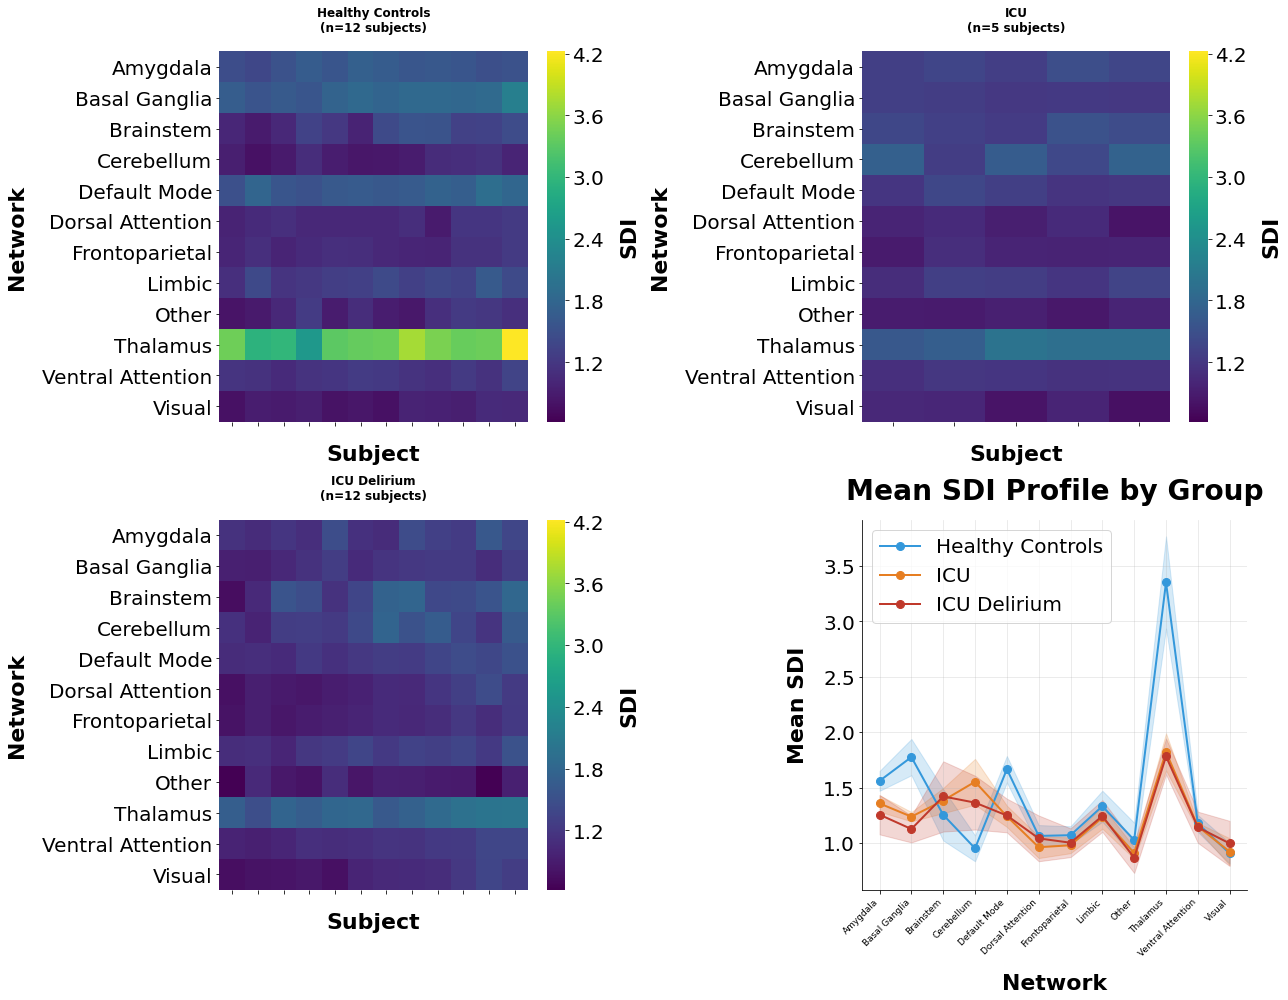


DIMENSIONALITY REDUCTION: Principal Component Analysis

PCA Explained Variance:
  PC1: 0.464 (46.4%)
  PC2: 0.264 (26.4%)
  PC3: 0.091 (9.1%)
  Total: 0.818 (81.8%)


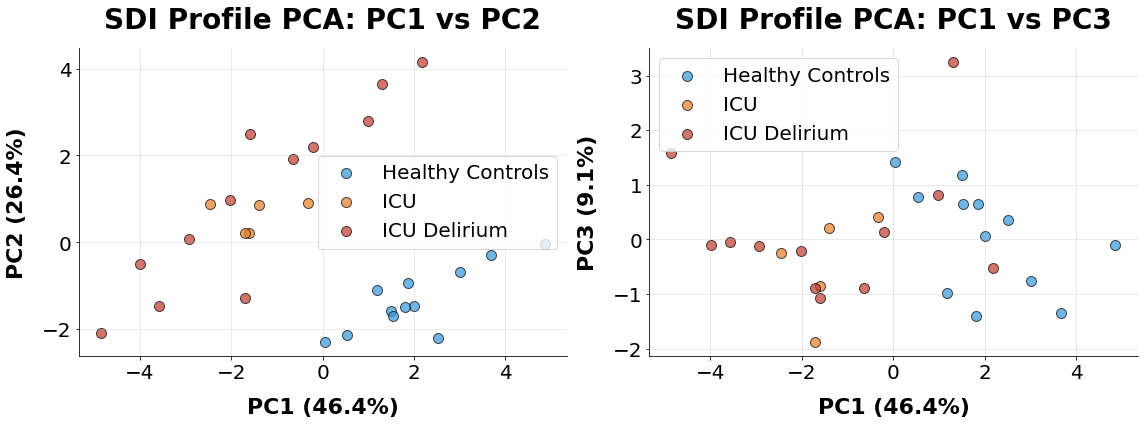


STATISTICAL TESTING: Group Separation in PCA Space

Principal Component Group Differences:
--------------------------------------------------------------------------------


,PC,Explained_Variance,KW_pvalue,HC_vs_ICU_p,HC_vs_Del_p,ICU_vs_Del_p,HC_mean,ICU_mean,Del_mean,KW_pvalue_corrected,significant
0,PC1,0.4637,0.0004,0.0003,0.0007,0.9593,2.0457,-1.4975,-1.4217,0.0013,True
1,PC2,0.2637,0.0016,0.0003,0.0035,0.6461,-1.3284,0.6117,1.0735,0.0024,True
2,PC3,0.0908,0.6715,0.3284,0.9310,0.6461,0.0379,-0.4718,0.1587,0.6715,False



✓ Significant group separation in 2 principal component(s)
  → Groups have distinct SDI profile patterns

NETWORK CONTRIBUTIONS TO GROUP SEPARATION
Networks with highest loadings on PC1 (main axis of group separation):
--------------------------------------------------------------------------------

Top 10 Networks Contributing to PC1:
  Default Mode: 0.394 (increases SDI → higher PC1)
  Basal Ganglia: 0.359 (increases SDI → higher PC1)
  Frontoparietal: 0.356 (increases SDI → higher PC1)
  Thalamus: 0.343 (increases SDI → higher PC1)
  Amygdala: 0.322 (increases SDI → higher PC1)
  Limbic: 0.310 (increases SDI → higher PC1)
  Ventral Attention: 0.302 (increases SDI → higher PC1)
  Dorsal Attention: 0.284 (increases SDI → higher PC1)
  Other: 0.204 (increases SDI → higher PC1)
  Cerebellum: -0.175 (decreases SDI → higher PC1)

Interpretation:
- SDI profiles represent each subject's pattern of structural-functional coupling across networks
- PCA identifies the main axes of variation in

In [22]:
# SDI Profile/Fingerprint Analysis
# Creates SDI "fingerprints" per subject and identifies distinct delirium patterns
if unified_sdi_df is not None and 'region_category' in unified_sdi_df.columns:
    try:
        print("=" * 80)
        print("SDI PROFILE/FINGERPRINT ANALYSIS")
        print("=" * 80)
        print("Creating SDI profiles (mean SDI per network) for each subject")
        print("Identifying distinct patterns and group separation")
        print("=" * 80)
        
        # Compute mean SDI per network per subject (SDI profile)
        # First get group labels for each subject
        subject_groups = unified_sdi_df.groupby('subject_id')['group'].first()
        
        # Compute SDI profiles (mean SDI per network per subject)
        sdi_profiles = unified_sdi_df.groupby(['subject_id', 'region_category'])['sdi_value'].mean().unstack(level='region_category')
        
        # Remove any networks with all NaN
        sdi_profiles = sdi_profiles.dropna(axis=1, how='all')
        
        # Ensure index is simple (not MultiIndex) - reset if needed
        if isinstance(sdi_profiles.index, pd.MultiIndex):
            sdi_profiles = sdi_profiles.reset_index(level=[i for i in range(1, len(sdi_profiles.index.names))], drop=True)
        
        print(f"\nSDI Profiles: {sdi_profiles.shape[0]} subjects × {sdi_profiles.shape[1]} networks")
        print(f"Groups: {subject_groups.value_counts().to_dict()}")
        
        # Visualize SDI profiles
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        
        # Plot 1: Heatmap of SDI profiles by group
        # Group subjects by group
        for idx, group in enumerate(['Healthy Controls', 'ICU', 'ICU Delirium']):
            group_subjects = subject_groups[subject_groups == group].index.tolist()
            # Filter profiles for this group
            group_profiles = sdi_profiles.loc[sdi_profiles.index.isin(group_subjects)]
            
            if len(group_profiles) > 0:
                # Sort by mean SDI across networks for better visualization
                group_profiles_sorted = group_profiles.loc[group_profiles.mean(axis=1).sort_values().index]
                
                ax = axes[idx // 2, idx % 2] if idx < 2 else axes[1, idx - 2]
                sns.heatmap(group_profiles_sorted.T, annot=False, fmt='.2f', cmap='viridis',
                           ax=ax, cbar_kws={'label': 'SDI'}, vmin=sdi_profiles.min().min(),
                           vmax=sdi_profiles.max().max())
                ax.set_title(f'{group}\n(n={len(group_profiles)} subjects)', 
                           fontweight='bold', pad=20, fontsize=12)
                ax.set_xlabel('Subject', fontweight='bold')
                ax.set_ylabel('Network', fontweight='bold')
                ax.set_xticklabels([])  # Remove subject labels for clarity
        
        # Plot 2: Mean SDI profile per group (line plot)
        ax = axes[1, 1]
        networks = sdi_profiles.columns
        for group in ['Healthy Controls', 'ICU', 'ICU Delirium']:
            group_subjects = subject_groups[subject_groups == group].index.tolist()
            group_profiles = sdi_profiles.loc[sdi_profiles.index.isin(group_subjects)]
            
            if len(group_profiles) > 0:
                mean_profile = group_profiles.mean(axis=0)
                std_profile = group_profiles.std(axis=0)
                
                x = np.arange(len(networks))
                color = colors[['Healthy Controls', 'ICU', 'ICU Delirium'].index(group)]
                ax.plot(x, mean_profile.values, marker='o', label=group, 
                       color=color, linewidth=2, markersize=8)
                ax.fill_between(x, mean_profile.values - std_profile.values,
                              mean_profile.values + std_profile.values,
                              alpha=0.2, color=color)
        
        ax.set_xlabel('Network', fontweight='bold')
        ax.set_ylabel('Mean SDI', fontweight='bold')
        ax.set_title('Mean SDI Profile by Group', fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(networks, rotation=45, ha='right', fontsize=9)
        ax.legend()
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Dimensionality reduction for visualization (PCA)
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        
        print("\n" + "=" * 80)
        print("DIMENSIONALITY REDUCTION: Principal Component Analysis")
        print("=" * 80)
        
        # Prepare data for PCA
        X = sdi_profiles.fillna(sdi_profiles.mean()).values  # Fill NaN with mean
        # Align subject_groups with sdi_profiles index
        y = subject_groups.reindex(sdi_profiles.index).values
        
        # Standardize
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # PCA
        pca = PCA(n_components=min(3, X_scaled.shape[1], X_scaled.shape[0]))
        X_pca = pca.fit_transform(X_scaled)
        
        print(f"\nPCA Explained Variance:")
        for i, var in enumerate(pca.explained_variance_ratio_):
            print(f"  PC{i+1}: {var:.3f} ({var*100:.1f}%)")
        print(f"  Total: {pca.explained_variance_ratio_.sum():.3f} ({pca.explained_variance_ratio_.sum()*100:.1f}%)")
        
        # Visualize PCA
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: PC1 vs PC2
        for i, group in enumerate(['Healthy Controls', 'ICU', 'ICU Delirium']):
            mask = y == group
            if np.any(mask):
                axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                              label=group, color=colors[i], s=100, alpha=0.7, edgecolors='black')
        
        axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
        axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
        axes[0].set_title('SDI Profile PCA: PC1 vs PC2', fontweight='bold', pad=20)
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        # Plot 2: PC1 vs PC3 (if available)
        if X_pca.shape[1] >= 3:
            for i, group in enumerate(['Healthy Controls', 'ICU', 'ICU Delirium']):
                mask = y == group
                if np.any(mask):
                    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 2], 
                                  label=group, color=colors[i], s=100, alpha=0.7, edgecolors='black')
            
            axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
            axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontweight='bold')
            axes[1].set_title('SDI Profile PCA: PC1 vs PC3', fontweight='bold', pad=20)
            axes[1].legend()
            axes[1].grid(alpha=0.3)
        else:
            axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Statistical testing: Compare group separation in PCA space
        from scipy.stats import kruskal, mannwhitneyu
        from statsmodels.stats.multitest import multipletests
        
        print("\n" + "=" * 80)
        print("STATISTICAL TESTING: Group Separation in PCA Space")
        print("=" * 80)
        
        pca_test_results = []
        for pc_idx in range(min(3, X_pca.shape[1])):
            hc_pc = X_pca[y == 'Healthy Controls', pc_idx]
            icu_pc = X_pca[y == 'ICU', pc_idx]
            del_pc = X_pca[y == 'ICU Delirium', pc_idx]
            
            if len(hc_pc) > 0 and len(icu_pc) > 0 and len(del_pc) > 0:
                # Kruskal-Wallis test
                kw_stat, kw_pval = kruskal(hc_pc, icu_pc, del_pc)
                
                # Pairwise comparisons
                u_hc_icu, p_hc_icu = mannwhitneyu(hc_pc, icu_pc, alternative='two-sided')
                u_hc_del, p_hc_del = mannwhitneyu(hc_pc, del_pc, alternative='two-sided')
                u_icu_del, p_icu_del = mannwhitneyu(icu_pc, del_pc, alternative='two-sided')
                
                pca_test_results.append({
                    'PC': f'PC{pc_idx+1}',
                    'Explained_Variance': pca.explained_variance_ratio_[pc_idx],
                    'KW_pvalue': kw_pval,
                    'HC_vs_ICU_p': p_hc_icu,
                    'HC_vs_Del_p': p_hc_del,
                    'ICU_vs_Del_p': p_icu_del,
                    'HC_mean': np.mean(hc_pc),
                    'ICU_mean': np.mean(icu_pc),
                    'Del_mean': np.mean(del_pc)
                })
        
        if len(pca_test_results) > 0:
            pca_test_df = pd.DataFrame(pca_test_results)
            pca_test_df['KW_pvalue_corrected'] = multipletests(
                pca_test_df['KW_pvalue'], method='fdr_bh', alpha=0.05
            )[1]
            pca_test_df['significant'] = pca_test_df['KW_pvalue_corrected'] < 0.05
            
            print("\nPrincipal Component Group Differences:")
            print("-" * 80)
            display(pca_test_df.round(4))
            
            sig_pcs = pca_test_df[pca_test_df['significant'] == True]
            if len(sig_pcs) > 0:
                print(f"\n✓ Significant group separation in {len(sig_pcs)} principal component(s)")
                print("  → Groups have distinct SDI profile patterns")
            else:
                print("\nNo significant group separation in PCA space")
        
        # Identify networks contributing most to group separation (PC1 loadings)
        print("\n" + "=" * 80)
        print("NETWORK CONTRIBUTIONS TO GROUP SEPARATION")
        print("=" * 80)
        print("Networks with highest loadings on PC1 (main axis of group separation):")
        print("-" * 80)
        
        pc1_loadings = pd.Series(pca.components_[0], index=networks)
        pc1_loadings_sorted = pc1_loadings.abs().sort_values(ascending=False)
        
        print("\nTop 10 Networks Contributing to PC1:")
        for network, loading in pc1_loadings_sorted.head(10).items():
            original_loading = pc1_loadings[network]
            direction = "increases" if original_loading > 0 else "decreases"
            print(f"  {network}: {original_loading:.3f} ({direction} SDI → higher PC1)")
        
        print("\nInterpretation:")
        print("- SDI profiles represent each subject's pattern of structural-functional coupling across networks")
        print("- PCA identifies the main axes of variation in SDI profiles")
        print("- Group separation in PCA space indicates distinct SDI patterns in delirium")
        print("- Networks with high PC1 loadings are most important for distinguishing groups")
        
    except Exception as e:
        print(f"Error in SDI profile/fingerprint analysis: {e}")
        import traceback
        traceback.print_exc()
